# 📘 Two-Wheeler Demand Forecasting
**Author:** Fotis Diamantidis <br>
**Goal:** Predict daily two-wheeler (scooter + bicycle + moped) demand.

# 1. Importing Libraries

In [2]:
# Core Python & Data Libraries
import os
import random
import time
import json
import pickle
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

# PyTorch (Deep Learning)
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split

# Scikit-Learn (Preprocessing)
from sklearn.preprocessing import StandardScaler

# Progress bar
from tqdm import tqdm

# Scipy for statistical tests
from scipy import stats

# Reproducibility Helper
def set_seed(seed=42):
    """Fix random seeds for reproducibility (CPU-only)."""
    random.seed(seed)          # For Python’s random module
    np.random.seed(seed)       # For NumPy random ops
    torch.manual_seed(seed)    # For PyTorch (CPU ops)
    os.environ["PYTHONHASHSEED"] = str(seed)  # Makes hashing deterministic

# Set seed globally
set_seed(42)

# 2. Loading the Dataset

In [3]:
# Configure data Types for the DataFrame creation. Integers are left out because NaNs generate an error.
dtypes = {
    'ID': 'string',
    'Device ID': 'string',
    'Vehicle Type': 'category',
    'Start Time': 'string',
    'End Time': 'string',
    'Modified Date': 'string',
    'Month': 'Int8',
    'Day of Week': 'Int8',
    'Year': 'Int16',
    'Council District Start': 'string',
    'Council District End': 'string',
    'Census Tract Start': 'string',
    'Census Tract End': 'string',
    # Not forcing dtypes for Trip Duration / Trip Distance here
}

# Configure ID as the index column.
index_cols = ['ID']

# Create the dataframe.
df = pd.read_csv("data/raw/Shared_Micromobility_Vehicle_Trips_2018-2022.csv", dtype=dtypes, low_memory=False, thousands=",")

#Save the original dataframe for comparison after cleaning the data for comparison purposes.
df_raw = df.copy()

# Use describe to search for outliers
df.describe()

,Trip Duration,Trip Distance,Month,Hour,Day of Week,Council District (Start),Council District (End),Year (US/Central)
count,1.504864e+07,1.504864e+07,15048635.0,1.504864e+07,15048635.0,1.502844e+07,1.502712e+07,1.504864e+07
mean,7.150060e+02,2.825117e+04,6.713849,1.266304e+01,3.497204,7.675822e+00,7.603119e+00,2.019657e+03
std,5.803378e+03,4.705075e+06,3.342199,8.310150e+00,2.036327,2.621605e+00,2.670329e+00,1.201316e+00
min,-8.616100e+04,-5.243139e+08,1.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,1.970000e+03
25%,2.390000e+02,4.960000e+02,4.0,4.000000e+00,2.0,9.000000e+00,9.000000e+00,2.019000e+03
50%,4.280000e+02,1.093000e+03,7.0,1.600000e+01,4.0,9.000000e+00,9.000000e+00,2.019000e+03
75%,8.020000e+02,2.075000e+03,10.0,2.000000e+01,5.0,9.000000e+00,9.000000e+00,2.021000e+03
max,1.548558e+07,2.239711e+09,12.0,2.300000e+01,6.0,1.000000e+01,1.000000e+01,2.022000e+03


# 3. Data Filtering & Cleaning

In [4]:
# 1. Save the initial number of rows before any cleaning
initial_rows = len(df)
df.columns = df.columns.str.strip()

# 1) Robust parsing Start/End Time
def parse_datetimes(series, fmts):
    s_raw = series.astype(str).str.strip()
    out = pd.Series(pd.NaT, index=series.index)
    for fmt in fmts:
        mask = out.isna()
        if not mask.any():
            break
        out.loc[mask] = pd.to_datetime(s_raw[mask], format=fmt, errors='coerce')
    mask = out.isna()
    if mask.any():
        out.loc[mask] = pd.to_datetime(s_raw[mask], errors='coerce', infer_datetime_format=True)
    return out

CANDIDATE_FORMATS = [
    '%m/%d/%Y %I:%M:%S %p',
    '%Y %b %d %I:%M:%S %p',
    '%Y-%m-%d %H:%M:%S',
    '%d/%m/%Y %H:%M',
]

df['Start Time'] = parse_datetimes(df['Start Time'], CANDIDATE_FORMATS)
df['End Time'] = parse_datetimes(df['End Time'], CANDIDATE_FORMATS)

# 1a) Count invalid
invalid_datetime_rows = df['Start Time'].isna().sum() + df['End Time'].isna().sum()

# 1b) Drop invalid datetimes
df = df.dropna(subset=['Start Time', 'End Time'])

# 2) Vehicle filter
before_vehicle = len(df)
df['Vehicle Type'] = df['Vehicle Type'].astype(str).str.strip().str.lower()

# Choose which vehicle type to keep
VEHICLE_TYPE = 'scooter'  # Options: 'scooter', 'bicycle', 'moped'

df = df[df['Vehicle Type'] == VEHICLE_TYPE]
print(f"✅ Filtered for {VEHICLE_TYPE.upper()} only.")
vehicle_rows_removed = before_vehicle - len(df)

if df.empty:
    raise ValueError(f"No data found for vehicle type '{VEHICLE_TYPE}'. Please check your dataset.")

# 3) OUT_OF_BOUNDS
oob_cols = [c for c in ['Census Tract Start','Census Tract End'] if c in df.columns]
if len(oob_cols) == 2:
    oob_mask = (
        df['Census Tract Start'].astype(str).str.contains('OUT_OF_BOUNDS', na=False) |
        df['Census Tract End'  ].astype(str).str.contains('OUT_OF_BOUNDS', na=False)
    )
    out_of_bounds_rows = int(oob_mask.sum())
    df = df[~oob_mask]
else:
    out_of_bounds_rows = 0

# 4) Numeric coercion
for col in ['Trip Duration','Trip Distance']:
    df[col] = df[col].astype(str).str.replace(',', '', regex=False).str.strip()
    df[col] = pd.to_numeric(df[col], errors='coerce')

before_na = len(df)
df = df.dropna(subset=['Trip Duration','Trip Distance'])
na_rows_removed = before_na - len(df)

# 5) Outliers
before_outliers = len(df)
df = df[(df['Trip Duration'] > 0) & (df['Trip Duration'] <= 43200)]
df = df[(df['Trip Distance'] > 0) & (df['Trip Distance'] <= 80467.2)]
after_outliers = len(df)
outlier_rows_removed = before_outliers - after_outliers

# 6a) Datetime features
df['Date']       = df['Start Time'].dt.date
df['Hour']       = df['Start Time'].dt.hour
df['DayOfWeek']  = df['Start Time'].dt.dayofweek
df['Month']      = df['Start Time'].dt.month

# Map months to seasons (0–3)
def month_to_season(month):
    if month in [12, 1, 2]:
        return 0  # Winter
    elif month in [3, 4, 5]:
        return 1  # Spring
    elif month in [6, 7, 8]:
        return 2  # Summer
    else:
        return 3  # Autumn

df['Season'] = df['Month'].apply(month_to_season)

# 6b) Cyclical encodings (temporal features)
df['Hour_sin']      = np.sin(2 * np.pi * df['Hour'] / 24)
df['Hour_cos']      = np.cos(2 * np.pi * df['Hour'] / 24)
df['DayOfWeek_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
df['DayOfWeek_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)
df['Month_sin']     = np.sin(2 * np.pi * df['Month'] / 12)
df['Month_cos']     = np.cos(2 * np.pi * df['Month'] / 12)
df['Season_sin']    = np.sin(2 * np.pi * df['Season'] / 4)
df['Season_cos']    = np.cos(2 * np.pi * df['Season'] / 4)

# 7) Final stats
final_rows = len(df)
rows_removed = initial_rows - final_rows

✅ Filtered for SCOOTER only.


# 4. Post-Cleaning Validation
## 4.1 Data Cleaning Report

In [5]:
print("🔍 Data Cleaning Report")
print("-" * 40)
print(f"Initial number of rows: {initial_rows:,}")
print(f"Final number of rows: {final_rows:,}")
print(f"Total rows removed: {rows_removed:,}")
print(f"1. Removed invalid datetime rows (Start/End Time): {invalid_datetime_rows:,}")
print(f"2. Removed 'OUT_OF_BOUNDS' location rows: {out_of_bounds_rows:,}")
print(f"3. Removed outlier rows (Duration & Distance): {outlier_rows_removed:,}")
print(f"Date range: {df['Start Time'].min().date()} to {df['Start Time'].max().date()}")
print(f"Number of unique days: {df['Date'].nunique():,}")
print(f"\nSelected vehicle type: {VEHICLE_TYPE.upper()}")
print(f"Total trips: {len(df):,}")

🔍 Data Cleaning Report
----------------------------------------
Initial number of rows: 15,048,635
Final number of rows: 13,450,269
Total rows removed: 1,598,366
1. Removed invalid datetime rows (Start/End Time): 0
2. Removed 'OUT_OF_BOUNDS' location rows: 53,821
3. Removed outlier rows (Duration & Distance): 881,676
Date range: 2018-04-03 to 2022-04-04
Number of unique days: 1,440

Selected vehicle type: SCOOTER
Total trips: 13,450,269


## 4.2 Visual Comparison: Before vs After Data Cleaning

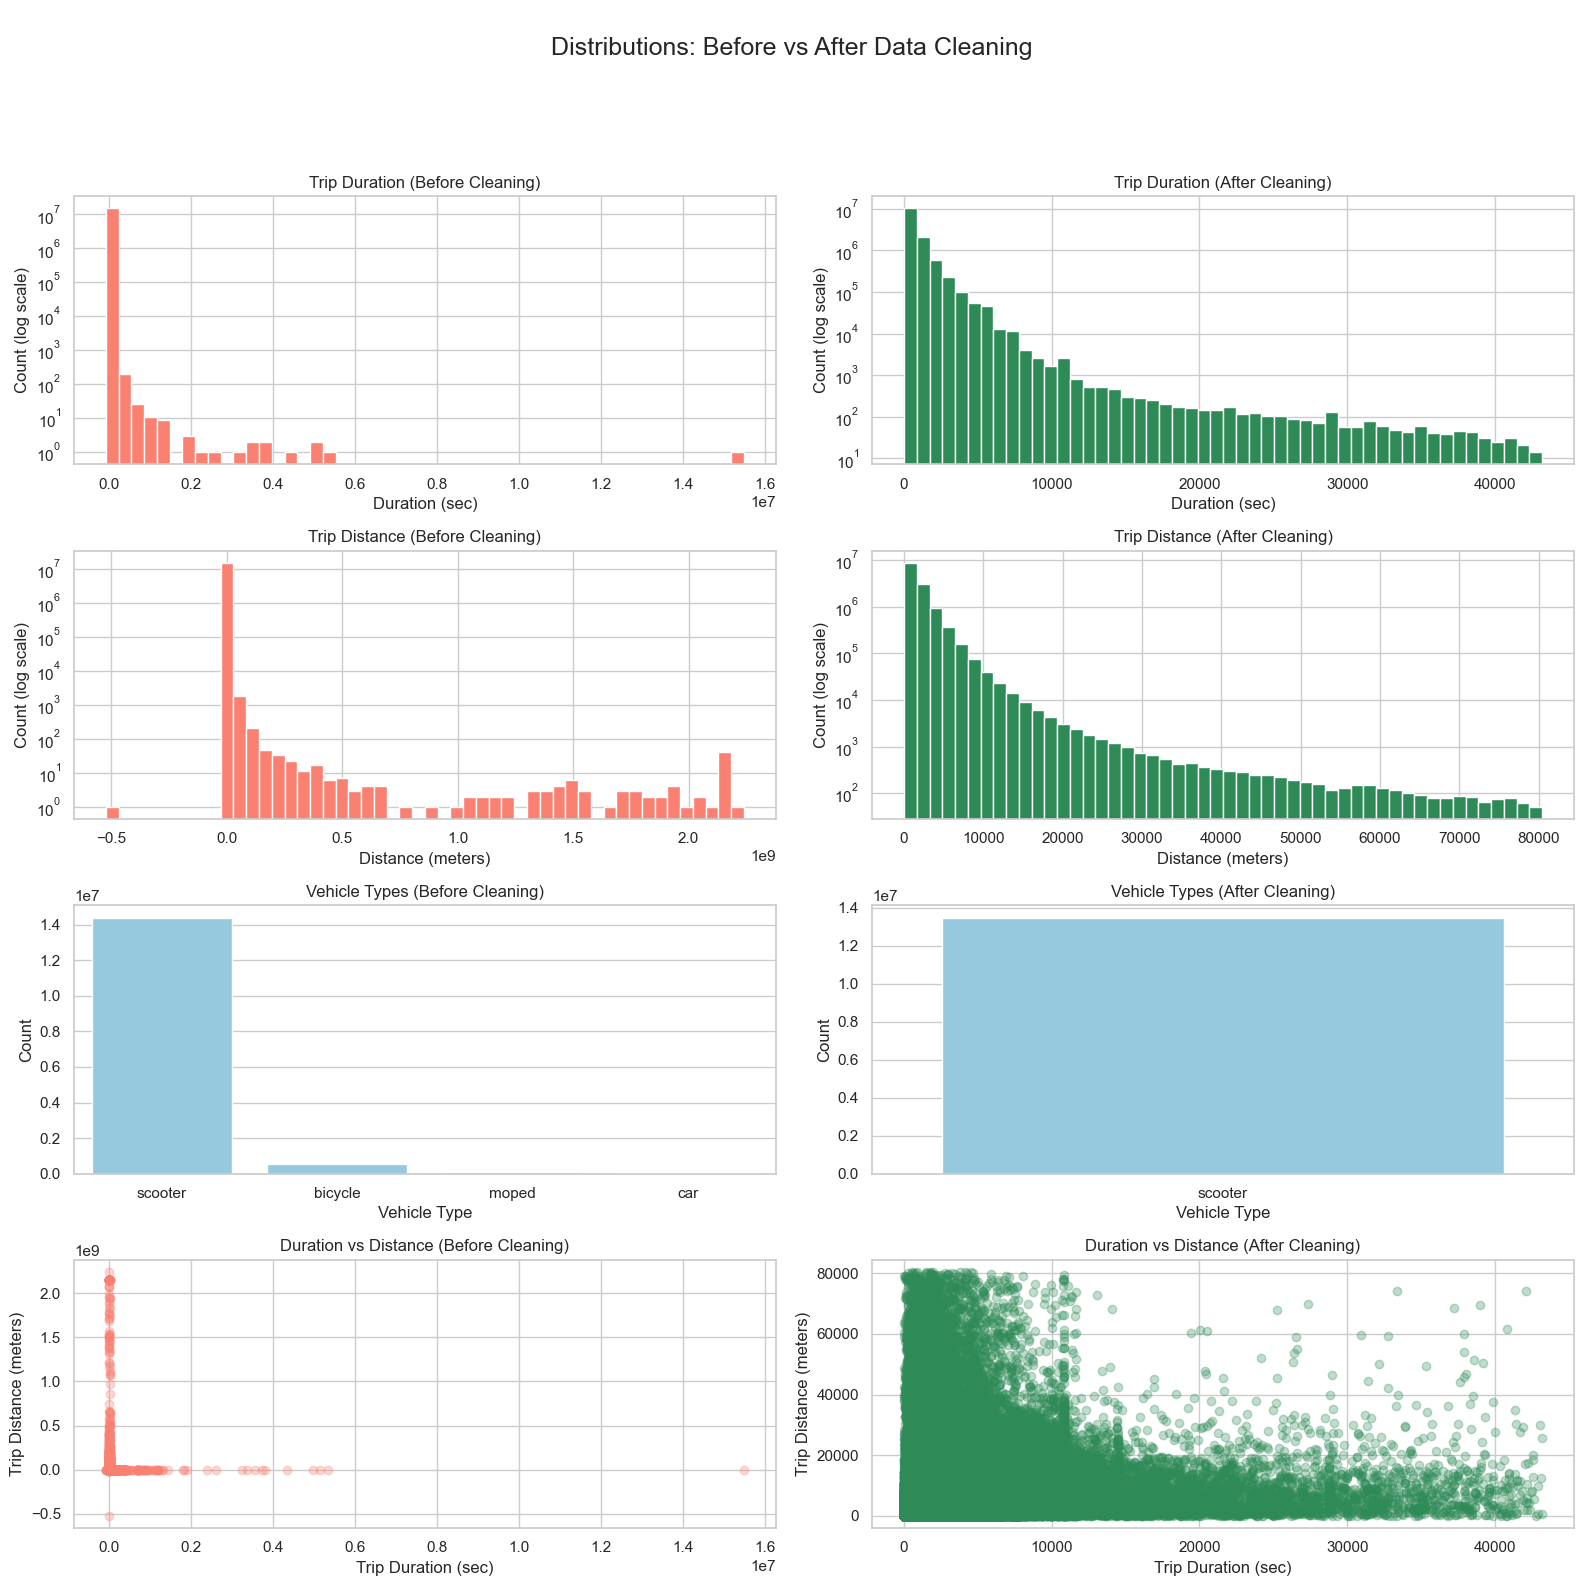

In [6]:
# Set visual style
sns.set(style="whitegrid")

# Normalize vehicle type labels for clearer before/after plots
df_raw['Vehicle Type'] = df_raw['Vehicle Type'].astype(str).str.strip().str.lower()
type_order = ['scooter', 'bicycle', 'moped', 'car']

# Create subplot grid: 4 rows x 2 columns
fig, axs = plt.subplots(4, 2, figsize=(16, 16))
fig.suptitle('\nDistributions: Before vs After Data Cleaning', fontsize=18, y=1.02)

# --- Trip Duration ---
# Question: Μετά τον καθαρισμό, σε ποια διάρκεια (sec) συγκεντρώνεται η πλειοψηφία των ταξιδιών;
axs[0, 0].hist(df_raw['Trip Duration'], bins=50, log=True, color='salmon')
axs[0, 0].set_title('Trip Duration (Before Cleaning)')
axs[0, 0].set_xlabel('Duration (sec)')
axs[0, 0].set_ylabel('Count (log scale)')

axs[0, 1].hist(df['Trip Duration'], bins=50, log=True, color='seagreen')
axs[0, 1].set_title('Trip Duration (After Cleaning)')
axs[0, 1].set_xlabel('Duration (sec)')
axs[0, 1].set_ylabel('Count (log scale)')

# --- Trip Distance ---
# Question: Μετά το φιλτράρισμα, ποια είναι η τυπική απόσταση για την οποία χρησιμοποιούνται τα δίτροχα;
axs[1, 0].hist(df_raw['Trip Distance'], bins=50, log=True, color='salmon')
axs[1, 0].set_title('Trip Distance (Before Cleaning)')
axs[1, 0].set_xlabel('Distance (meters)')
axs[1, 0].set_ylabel('Count (log scale)')

axs[1, 1].hist(df['Trip Distance'], bins=50, log=True, color='seagreen')
axs[1, 1].set_title('Trip Distance (After Cleaning)')
axs[1, 1].set_xlabel('Distance (meters)')
axs[1, 1].set_ylabel('Count (log scale)')

# --- Vehicle Type ---
# Question: Ποια είναι η τελική κατανομή του στόλου μας μετά το φιλτράρισμα;
sns.countplot(x='Vehicle Type', data=df_raw, order=type_order, ax=axs[2, 0], color='skyblue')
axs[2, 0].set_title('Vehicle Types (Before Cleaning)')
axs[2, 0].set_ylabel('Count')

sns.countplot(x='Vehicle Type', data=df, ax=axs[2, 1], color='skyblue')
axs[2, 1].set_title('Vehicle Types (After Cleaning)')
axs[2, 1].set_ylabel('Count')

# --- Duration vs Distance ---
# Question: Μετά τον καθαρισμό, ποια είναι η τελική, υγιής συσχέτιση μεταξύ διάρκειας και απόστασης;
axs[3, 0].scatter(df_raw['Trip Duration'], df_raw['Trip Distance'], alpha=0.3, color='salmon')
axs[3, 0].set_title('Duration vs Distance (Before Cleaning)')
axs[3, 0].set_xlabel('Trip Duration (sec)')
axs[3, 0].set_ylabel('Trip Distance (meters)')

axs[3, 1].scatter(df['Trip Duration'], df['Trip Distance'], alpha=0.3, color='seagreen')
axs[3, 1].set_title('Duration vs Distance (After Cleaning)')
axs[3, 1].set_xlabel('Trip Duration (sec)')
axs[3, 1].set_ylabel('Trip Distance (meters)')

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

# 5. Aggregated Daily Dataset

In [7]:
# 5.1 Group by Date (ημερήσια σύνοψη)
daily_data = df.groupby('Date').agg({
    'ID': 'count',                                 # Total trips per day
    'Device ID': 'nunique',                        # Active devices (supply proxy)
    'Trip Duration': ['mean', 'std', 'median'],
    'Trip Distance': ['mean', 'std', 'median'],
    'Hour': lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else np.nan,  # Peak hour
    'DayOfWeek': 'first',
    'Month': 'first',
    'Season': 'first',
}).reset_index()

# 5.2 Flatten multi-level columns
daily_data.columns = [
    'Date', 'TotalTrips', 'TotalUniqueDevices',
    'AvgDuration', 'StdDuration', 'MedianDuration',
    'AvgDistance', 'StdDistance', 'MedianDistance',
    'PeakHour', 'DayOfWeek', 'Month', 'Season'
]

# 5.3 Set Date as index, sort, and fill calendar gaps
daily_data['Date'] = pd.to_datetime(daily_data['Date'])
daily_data = daily_data.set_index('Date').sort_index()

# Create full date range
full_index = pd.date_range(start=daily_data.index.min(), end=daily_data.index.max(), freq='D')
daily_data_filled = daily_data.reindex(full_index)

# 5.4 Flag synthetic days
daily_data_filled['IsSynthetic'] = daily_data_filled['TotalTrips'].isna().astype(int)

# 5.5 Fill numeric columns (FORWARD FILL - Conservative approach)
cols_fill = [
    'TotalTrips', 'TotalUniqueDevices',
    'AvgDuration', 'StdDuration', 'MedianDuration',
    'AvgDistance', 'StdDistance', 'MedianDistance',
    'PeakHour'
]

# Χρησιμοποιούμε ffill για ομαλή συνέχεια (χωρίς leakage)
daily_data_filled[cols_fill] = (
    daily_data_filled[cols_fill]
        .ffill()     # πάρε τελευταία γνωστή τιμή
        .fillna(0)   # αν δεν υπάρχει τίποτα πριν, βάλε 0
)

# Recalculate calendar features for synthetic days
daily_data_filled['DayOfWeek'] = daily_data_filled.index.dayofweek
daily_data_filled['Month'] = daily_data_filled.index.month
daily_data_filled['Season'] = daily_data_filled.index.month.map(
    lambda m: 0 if m in [12, 1, 2]
    else (1 if m in [3, 4, 5]
    else (2 if m in [6, 7, 8]
    else 3))
)
daily_data_filled['PeakHour'] = daily_data_filled['PeakHour'].fillna(0)

# 5.6 Back to DataFrame
daily_data = daily_data_filled.reset_index().rename(columns={'index': 'Date'})
daily_data = daily_data.sort_values('Date').reset_index(drop=True)

# 5.7 PAST-ONLY Features (χρησιμοποιούν μόνο προηγούμενες ημέρες)
daily_data = daily_data.sort_values('Date').reset_index(drop=True)  # Πρώτα ταξινόμηση κατά Date

# Target lags (PAST-ONLY)
daily_data['TotalTrips_Lag1'] = daily_data['TotalTrips'].shift(1).fillna(0)  # Πόσα trips έγιναν την προηγούμενη ημέρα
daily_data['TotalTrips_Lag7'] = daily_data['TotalTrips'].shift(7).fillna(0)  # Πόσα trips έγιναν μία εβδομάδα πριν

# Rolling means (PAST-ONLY)
daily_data['TotalTrips_Roll7']  = daily_data['TotalTrips'].shift(1).rolling(7, min_periods=1).mean().fillna(0)  # Μέσος όρος ζήτησης των τελευταίων 7 ημερών
daily_data['TotalTrips_Roll30'] = daily_data['TotalTrips'].shift(1).rolling(30, min_periods=1).mean().fillna(0)  # Μέσος όρος ζήτησης των τελευταίων 30 ημερών

# Trend proxy (PAST-ONLY)
daily_data['Trend14'] = daily_data['TotalTrips'].shift(1).rolling(14, min_periods=1).mean().fillna(0)  # Ομαλή τάση (μέσος όρος 14 ημερών)

# Supply features (PAST-ONLY)
daily_data['Devices_Roll7']  = daily_data['TotalUniqueDevices'].shift(1).rolling(7, min_periods=1).mean().fillna(0)  # Μέσος όρος συσκευών των τελευταίων 7 ημερών
daily_data['Devices_Roll30'] = daily_data['TotalUniqueDevices'].shift(1).rolling(30, min_periods=1).mean().fillna(0)  # Μέσος όρος συσκευών τελευταίων 30 ημερών
daily_data['Devices_Lag1']   = daily_data['TotalUniqueDevices'].shift(1).fillna(0)  # Πόσες συσκευές ήταν ενεργές χθες

# 5.8 Final copy for downstream steps & save
aggregated_daily_df = daily_data.copy()

# Optimize memory usage
float_cols = aggregated_daily_df.select_dtypes(include=[np.number]).columns
aggregated_daily_df[float_cols] = aggregated_daily_df[float_cols].astype(np.float32)

# Save processed dataset
aggregated_daily_df.to_csv('data/processed/final_daily_micromobility_data.csv', index=False)
print("✅ Aggregated data saved to 'data/processed/final_daily_micromobility_data.csv'")
print(f"   Total days: {len(aggregated_daily_df)}")
print(f"   Date range: {aggregated_daily_df['Date'].min()} to {aggregated_daily_df['Date'].max()}")
print(f"   Synthetic days: {aggregated_daily_df['IsSynthetic'].sum()}")

✅ Aggregated data saved to 'data/processed/final_daily_micromobility_data.csv'
   Total days: 1463
   Date range: 2018-04-03 00:00:00 to 2022-04-04 00:00:00
   Synthetic days: 23.0


# 6. Visualisation of Aggregated Data

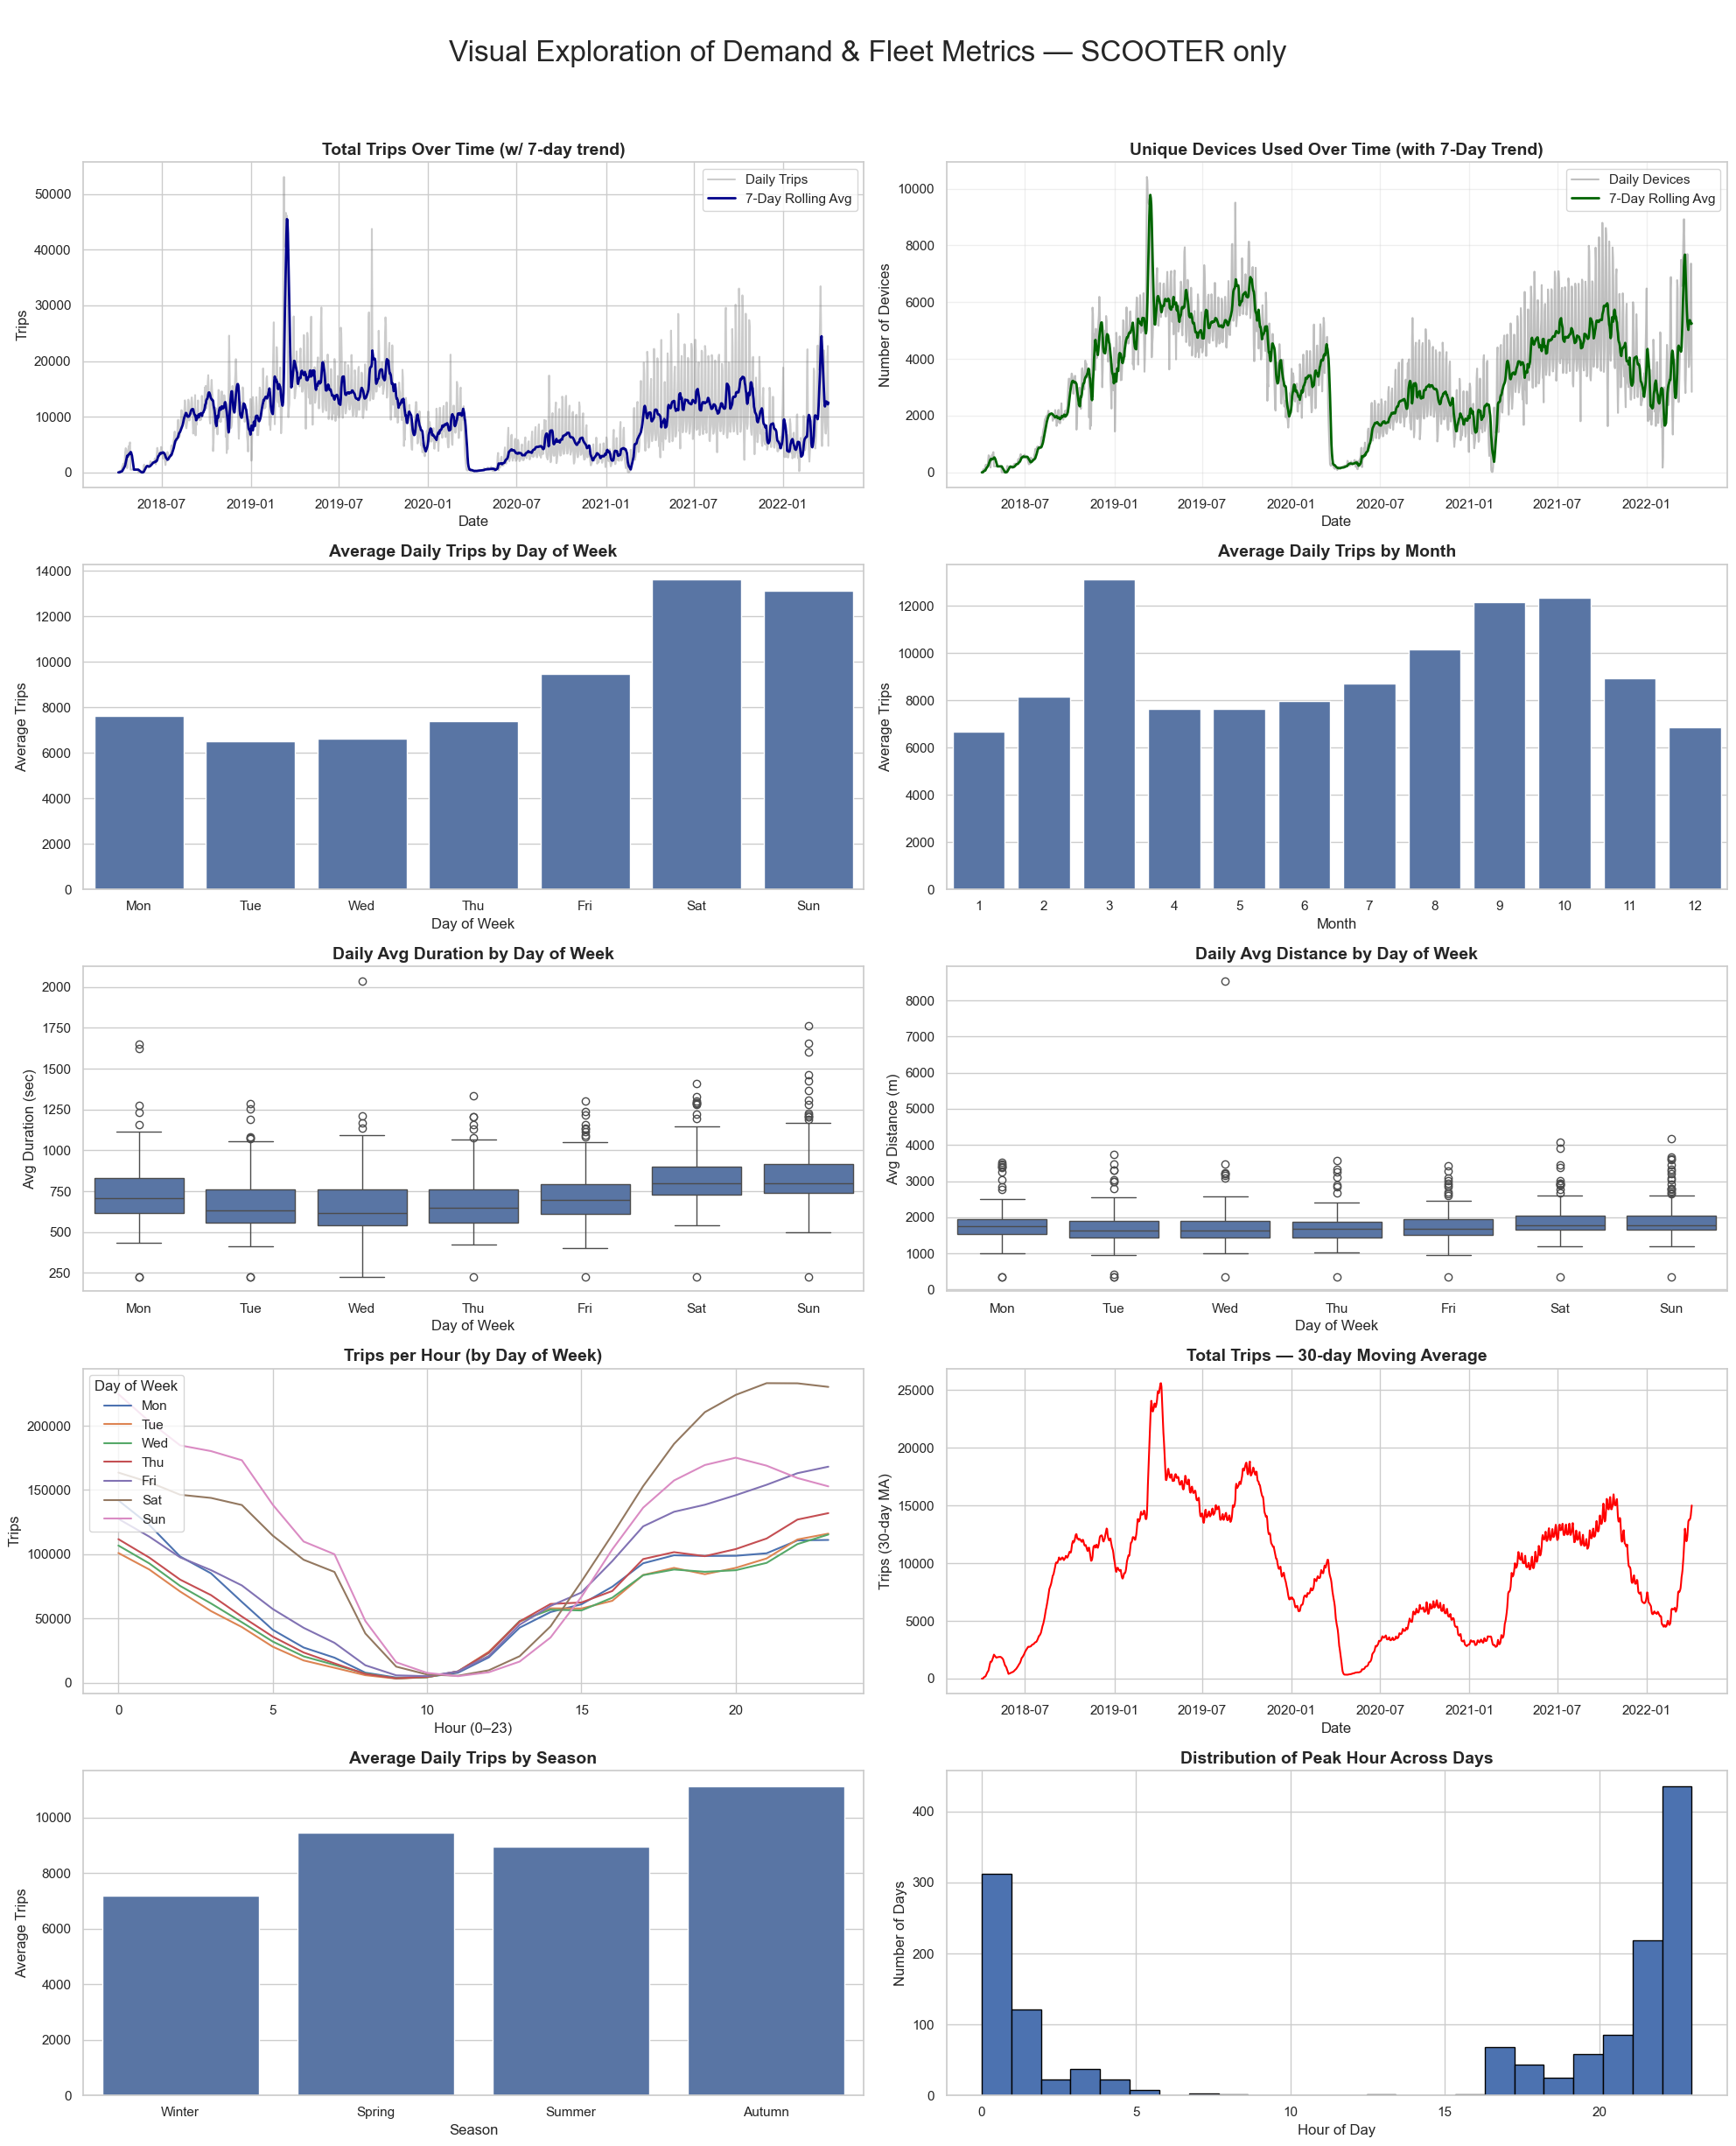

In [8]:
# Ensure Date is datetime
daily_data['Date'] = pd.to_datetime(daily_data['Date'])

# Pretty labels for day-of-week / season
day_map = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
season_map = {0: 'Winter', 1: 'Spring', 2: 'Summer', 3: 'Autumn'}

# Convenience columns for plotting
daily_data = daily_data.copy()
daily_data['DayOfWeek_Name'] = daily_data['DayOfWeek'].map(day_map)
daily_data['Season_Name']    = daily_data['Season'].map(season_map)

# Title suffix to show the active vehicle type
title_suffix = f" — {VEHICLE_TYPE.upper()} only"

sns.set(style="whitegrid")

# Create subplot grid
fig, axes = plt.subplots(5, 2, figsize=(20, 25))
fig.suptitle("\nVisual Exploration of Demand & Fleet Metrics" + title_suffix,
             fontsize=24, y=1.01)

axes_flat = axes.flatten()

# ---------------------- ΚΑΤΗΓΟΡΙΑ 1: ΖΗΤΗΣΗ & ΠΡΟΣΦΟΡΑ ΣΤΟ ΧΡΟΝΟ ----------------------
# Ερώτηση 1: Υπάρχουν μεσοπρόθεσμες τάσεις ή διακυμάνσεις στη ζήτηση;
sns.lineplot(data=daily_data, x="Date", y="TotalTrips", ax=axes_flat[0], label='Daily Trips', alpha=0.4, color='gray')
sns.lineplot(data=daily_data, x="Date", y="TotalTrips_Roll7", ax=axes_flat[0], label='7-Day Rolling Avg', linewidth=2, color='darkblue')
axes_flat[0].set_title("Total Trips Over Time (w/ 7-day trend)", fontsize=14, fontweight='bold')
axes_flat[0].set_xlabel("Date"); axes_flat[0].set_ylabel("Trips"); axes_flat[0].legend()

# Ερώτηση 2: Ακολουθεί η προσφορά (συσκευές) τη ζήτηση μέσα στο χρόνο;
sns.lineplot(data=daily_data, x="Date", y="TotalUniqueDevices", ax=axes_flat[1], label='Daily Devices', color='gray', alpha=0.5)
sns.lineplot(data=daily_data, x="Date", y="Devices_Roll7", ax=axes_flat[1], label='7-Day Rolling Avg', color='darkgreen', linewidth=2)
axes_flat[1].set_title("Unique Devices Used Over Time (with 7-Day Trend)", fontsize=14, fontweight='bold')
axes_flat[1].set_xlabel("Date"); axes_flat[1].set_ylabel("Number of Devices")
axes_flat[1].legend(); axes_flat[1].grid(True, alpha=0.3)

# ---------------------- ΚΑΤΗΓΟΡΙΑ 2: ΕΠΟΧΙΚΟΤΗΤΑ ----------------------
# Ερώτηση 3: Ποιες ημέρες της εβδομάδας έχουν τη μεγαλύτερη μέση ζήτηση;
dow_avg = (daily_data.groupby("DayOfWeek", as_index=False)["TotalTrips"].mean()
           .assign(DayOfWeek_Name=lambda x: x['DayOfWeek'].map(day_map))
           .sort_values('DayOfWeek'))
sns.barplot(data=dow_avg, x="DayOfWeek_Name", y="TotalTrips", ax=axes_flat[2])
axes_flat[2].set_title("Average Daily Trips by Day of Week", fontsize=14, fontweight='bold')
axes_flat[2].set_xlabel("Day of Week"); axes_flat[2].set_ylabel("Average Trips")

# Ερώτηση 4: Ποιοι μήνες παρουσιάζουν την υψηλότερη ζήτηση;
month_avg = daily_data.groupby("Month", as_index=False)["TotalTrips"].mean()
sns.barplot(data=month_avg, x="Month", y="TotalTrips", ax=axes_flat[3])
axes_flat[3].set_title("Average Daily Trips by Month", fontsize=14, fontweight='bold')
axes_flat[3].set_xlabel("Month"); axes_flat[3].set_ylabel("Average Trips")

# ---------------------- ΚΑΤΗΓΟΡΙΑ 3: ΧΑΡΑΚΤΗΡΙΣΤΙΚΑ ΤΑΞΙΔΙΩΝ ----------------------
# Ερώτηση 5: Διαφέρουν οι μέσες διάρκειες ταξιδιών ανά ημέρα της εβδομάδας;
sns.boxplot(data=daily_data, x="DayOfWeek_Name", y="AvgDuration", ax=axes_flat[4], order=[day_map[d] for d in range(7)])
axes_flat[4].set_title("Daily Avg Duration by Day of Week", fontsize=14, fontweight='bold')
axes_flat[4].set_xlabel("Day of Week"); axes_flat[4].set_ylabel("Avg Duration (sec)")

# Ερώτηση 6: Υπάρχουν διαφορές στις αποστάσεις ανά ημέρα της εβδομάδας;
sns.boxplot(data=daily_data, x="DayOfWeek_Name", y="AvgDistance", ax=axes_flat[5], order=[day_map[d] for d in range(7)])
axes_flat[5].set_title("Daily Avg Distance by Day of Week", fontsize=14, fontweight='bold')
axes_flat[5].set_xlabel("Day of Week"); axes_flat[5].set_ylabel("Avg Distance (m)")

# ---------------------- ΚΑΤΗΓΟΡΙΑ 4: ΩΡΙΑΙΑ & ΜΑΚΡΟΧΡΟΝΙΕΣ ΤΑΣΕΙΣ ----------------------
# Ερώτηση 7: Πώς μεταβάλλεται το ωριαίο προφίλ χρήσης ανά ημέρα της εβδομάδας;
hour_day_df = df.groupby(['Hour', 'DayOfWeek'])['ID'].count().reset_index()
pivot_hour_day = hour_day_df.pivot(index='Hour', columns='DayOfWeek', values='ID')
pivot_hour_day.columns = [day_map[i] for i in sorted(pivot_hour_day.columns)]
pivot_hour_day.plot(ax=axes_flat[6], legend=False)
axes_flat[6].legend(title='Day of Week', labels=pivot_hour_day.columns, loc='upper left')
axes_flat[6].set_title("Trips per Hour (by Day of Week)", fontsize=14, fontweight='bold')
axes_flat[6].set_xlabel("Hour (0–23)"); axes_flat[6].set_ylabel("Trips")

# Ερώτηση 8: Υπάρχουν μακροχρόνιες μεταβολές στη συνολική ζήτηση;
sns.lineplot(data=daily_data, x="Date", y="TotalTrips_Roll30", ax=axes_flat[7], color='red')
axes_flat[7].set_title("Total Trips — 30-day Moving Average", fontsize=14, fontweight='bold')
axes_flat[7].set_xlabel("Date"); axes_flat[7].set_ylabel("Trips (30-day MA)")
axes_flat[7].grid(True)

# ---------------------- ΚΑΤΗΓΟΡΙΑ 5: ΕΠΟΧΕΣ & ΩΡΕΣ ΚΟΡΥΦΩΣΗΣ ----------------------
# Ερώτηση 9: Ποια εποχή του έτους έχει τη μεγαλύτερη μέση ζήτηση;
season_avg = daily_data.groupby("Season_Name", as_index=False)["TotalTrips"].mean()
sns.barplot(data=season_avg, x="Season_Name", y="TotalTrips", ax=axes_flat[8], order=['Winter', 'Spring', 'Summer', 'Autumn'])
axes_flat[8].set_title("Average Daily Trips by Season", fontsize=14, fontweight='bold')
axes_flat[8].set_xlabel("Season"); axes_flat[8].set_ylabel("Average Trips")

# Ερώτηση 10: Ποιες ώρες της ημέρας παρατηρείται κορύφωση στη ζήτηση;
axes_flat[9].hist(daily_data['PeakHour'].fillna(0), bins=24, edgecolor='black')
axes_flat[9].set_title("Distribution of Peak Hour Across Days", fontsize=14, fontweight='bold')
axes_flat[9].set_xlabel("Hour of Day"); axes_flat[9].set_ylabel("Number of Days")

plt.tight_layout(rect=[0, 0.03, 1, 0.99])
plt.show()

# 7. Building & Training the LSTM/GRU Model
## 7.1. Final Feature Preparation and Data Partitioning
### 7.1.1. Feature Engineering and Dataset Splitting

In [11]:
try:
    daily_data = pd.read_csv('data/processed/final_daily_micromobility_data.csv', parse_dates=['Date'])
    aggregated_daily_df = daily_data.copy()
    print("✅ Aggregated data loaded for modeling.")
except FileNotFoundError:
    raise FileNotFoundError("data/processed/final_daily_micromobility_data.csv not found. Run Section 5 first.")

# 2) Sort & date sanity checks
daily_data = daily_data.sort_values('Date').reset_index(drop=True)
assert daily_data['Date'].is_monotonic_increasing, "Dates are not monotonic."
assert daily_data['Date'].duplicated().sum() == 0, "Found duplicated dates."

# 3) Recompute cyclical encodings (ημερήσιο επίπεδο)
daily_data['DayOfWeek'] = daily_data['DayOfWeek'].astype(int)
daily_data['Month']     = daily_data['Month'].astype(int)
daily_data['Season']    = daily_data['Season'].astype(int)

daily_data['DayOfWeek_sin'] = np.sin(2 * np.pi * daily_data['DayOfWeek'] / 7)
daily_data['DayOfWeek_cos'] = np.cos(2 * np.pi * daily_data['DayOfWeek'] / 7)
daily_data['Month_sin']     = np.sin(2 * np.pi * daily_data['Month'] / 12)
daily_data['Month_cos']     = np.cos(2 * np.pi * daily_data['Month'] / 12)
daily_data['Season_sin']    = np.sin(2 * np.pi * daily_data['Season'] / 4)
daily_data['Season_cos']    = np.cos(2 * np.pi * daily_data['Season'] / 4)

# 4) Τελική λίστα features
INPUT_FEATURES = [
    # Calendar
    'DayOfWeek_sin', 'DayOfWeek_cos',
    'Month_sin', 'Month_cos',
    'Season_sin', 'Season_cos',
    
    # Demand - lag only
    'TotalTrips_Lag1',      # Most recent demand (t-1)
    'TotalTrips_Lag7',      # Weekly seasonality (t-7)
    
    # Supply - current only
    'TotalUniqueDevices',   # Current fleet availability
    
    # Trip characteristics
    'MedianDuration',
    'MedianDistance'
]
TARGET = 'TotalTrips'

print(f"📊 Selected Features: {len(INPUT_FEATURES)}")

# 5) Extract features & target
X = daily_data[INPUT_FEATURES].to_numpy(dtype=np.float32)
Y = np.log1p(daily_data[TARGET].to_numpy(dtype=np.float32)).reshape(-1, 1)  # log1p transform

# 6) Remove warm-up period (first 30 days with unstable lagged features)
WARMUP_DAYS = 30
X = X[WARMUP_DAYS:]
Y = Y[WARMUP_DAYS:]
daily_data = daily_data.iloc[WARMUP_DAYS:].reset_index(drop=True)

print(f"✅ After warm-up removal: {len(X)} days remaining")

# 7) Time-series split: Train (80%) | Test (20%) — contiguous, preserves chronology
split_point = int(len(X) * 0.8)
X_train, X_test = X[:split_point], X[split_point:]
Y_train, Y_test = Y[:split_point], Y[split_point:]

print(f"\n📊 Data Split:")
print(f"   Total: {len(X)} days")
print(f"   Train: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"   Test:  {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")

✅ Aggregated data loaded for modeling.
📊 Selected Features: 11
✅ After warm-up removal: 1433 days remaining

📊 Data Split:
   Total: 1433 days
   Train: 1146 (80.0%)
   Test:  287 (20.0%)


### 7.1.2. Feature Correlation Matrix


📊 FEATURE CORRELATION ANALYSIS (Train only)
✅ No highly correlated feature pairs found (|r| > 0.9).


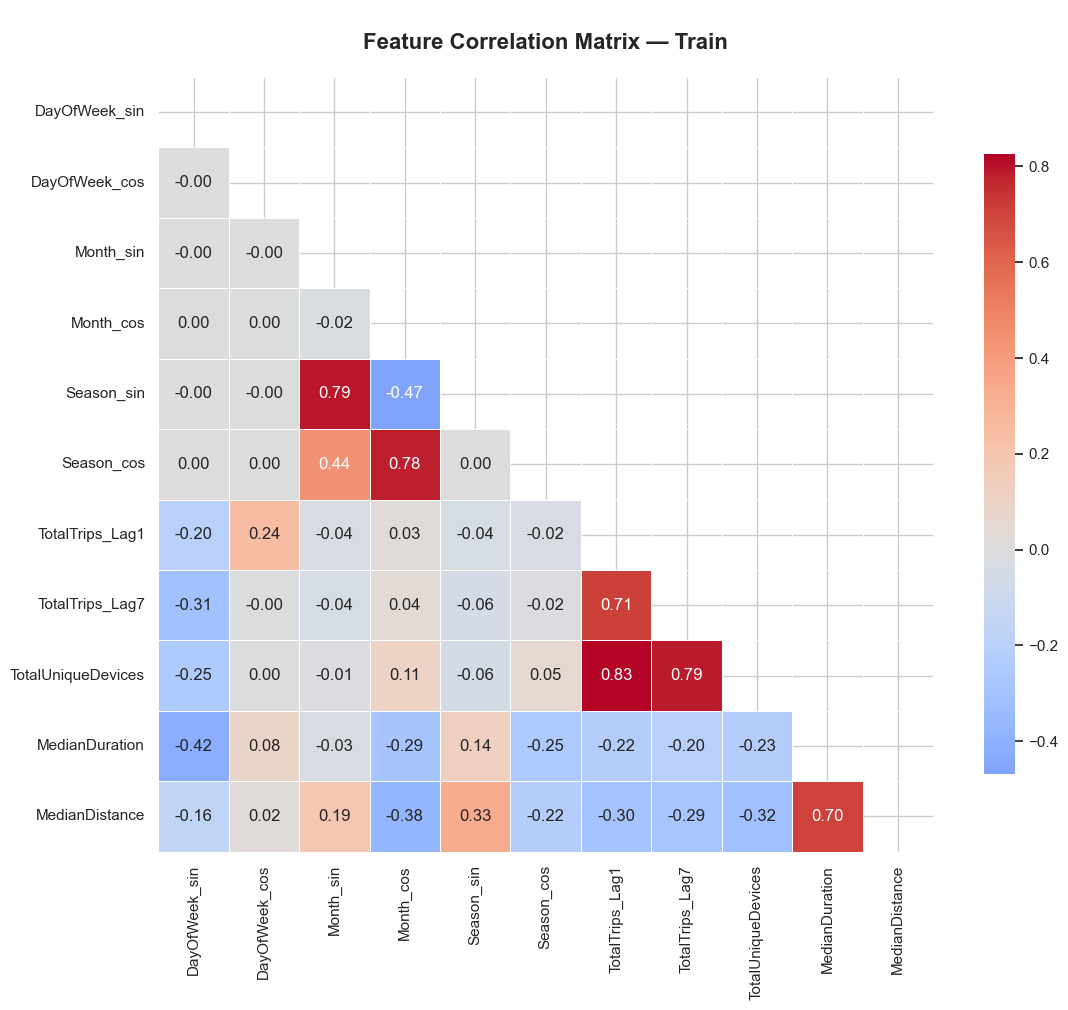

In [12]:
print("\n" + "="*70)
print("📊 FEATURE CORRELATION ANALYSIS (Train only)")
print("="*70)

# Το correlation matrix δείχνει τις γραμμικές σχέσεις (Pearson correlation) ανάμεσα σε κάθε ζεύγος χαρακτηριστικών.

# Use the SELECTED features from 7.1.1
corr_df = pd.DataFrame(X_train, columns=INPUT_FEATURES)
corr_matrix = corr_df.corr(numeric_only=True)

threshold = 0.90
high_corr_pairs = []
cols = corr_matrix.columns.tolist()
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        r = corr_matrix.iloc[i, j]
        if np.isfinite(r) and abs(r) > threshold:
            high_corr_pairs.append((cols[i], cols[j], float(r)))

if high_corr_pairs:
    print(f"\n⚠️ Highly correlated pairs (|r| > {threshold}):")
    for f1, f2, r in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True):
        print(f"   {f1:22s} ↔ {f2:22s} : r = {r:6.3f}")
else:
    print(f"✅ No highly correlated feature pairs found (|r| > {threshold}).")

# Correlation heatmap
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f',
            cmap='coolwarm', center=0, square=True,
            linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title("\nFeature Correlation Matrix — Train", 
          fontsize=16, pad=20, fontweight='bold')
plt.tight_layout()
plt.show()

### 7.1.3. Multicollinearity Assessment with Variance Inflation Factor (VIF)


📊 MULTICOLLINEARITY ANALYSIS

⚠️  Variance Inflation Factor (VIF) Analysis:
   Rule: VIF > 10 indicates moderate multicollinearity
   Rule: VIF > 100 indicates severe multicollinearity
----------------------------------------------------------------------
           Feature       VIF
    MedianDistance 40.331978
    MedianDuration 40.123920
TotalUniqueDevices 16.454477
   TotalTrips_Lag1 10.904563
   TotalTrips_Lag7  7.491544
         Month_cos  6.119761
        Season_sin  5.926142
         Month_sin  5.731499
        Season_cos  5.708171
     DayOfWeek_cos  1.260705
     DayOfWeek_sin  1.240523

⚠️  Moderate multicollinearity detected:
   - MedianDistance            (VIF: 40.3)
   - MedianDuration            (VIF: 40.1)
   - TotalUniqueDevices        (VIF: 16.5)
   - TotalTrips_Lag1           (VIF: 10.9)

   Note: VIF 10-50 is acceptable for deep learning models with regularization.


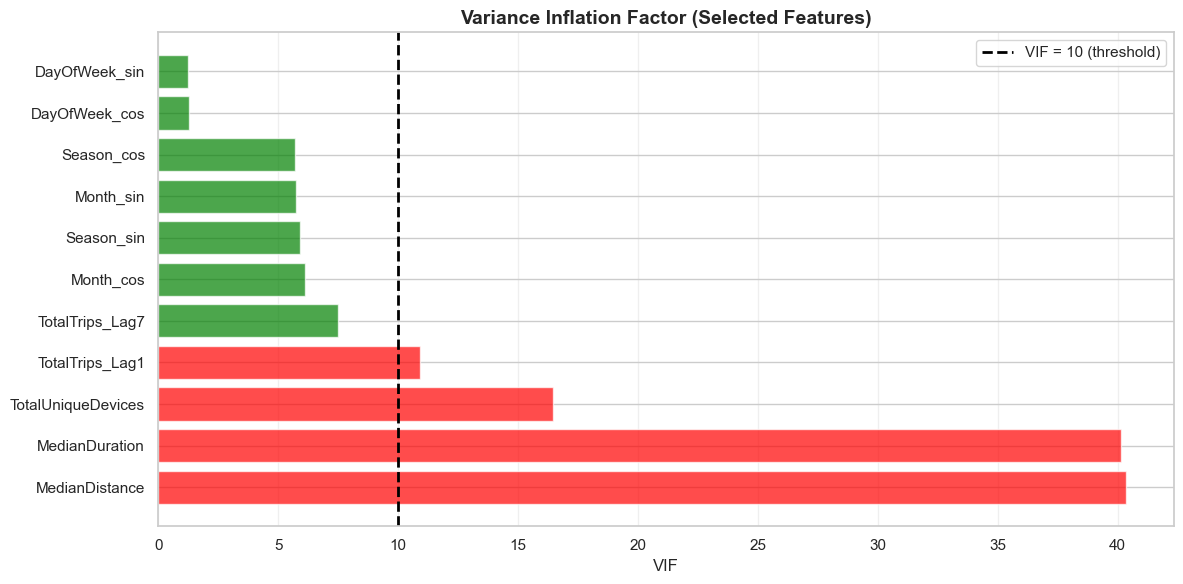

In [13]:
print("\n" + "="*70)
print("📊 MULTICOLLINEARITY ANALYSIS")
print("="*70)

# Ο VIF μετράει πόσο αυξάνεται η διακύμανση (variance) των εκτιμήσεων ενός feature εξαιτίας της γραμμικής σχέσης του με τα υπόλοιπα features.

def calculate_vif(df):
    """Calculate VIF for each feature."""
    vif_data = pd.DataFrame()
    vif_data["Feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) 
                       for i in range(len(df.columns))]
    return vif_data.sort_values('VIF', ascending=False)

# Calculate VIF on selected features
vif_df = calculate_vif(corr_df)

print("\n⚠️  Variance Inflation Factor (VIF) Analysis:")
print("   Rule: VIF > 10 indicates moderate multicollinearity")
print("   Rule: VIF > 100 indicates severe multicollinearity")
print("-" * 70)
print(vif_df.to_string(index=False))

high_vif = vif_df[vif_df['VIF'] > 10]['Feature'].tolist()
severe_vif = vif_df[vif_df['VIF'] > 100]['Feature'].tolist()

if len(high_vif) > 0:
    print(f"\n⚠️  Moderate multicollinearity detected:")
    for feat in high_vif:
        vif_val = vif_df[vif_df['Feature'] == feat]['VIF'].values[0]
        print(f"   - {feat:25s} (VIF: {vif_val:.1f})")
    print("\n   Note: VIF 10-50 is acceptable for deep learning models with regularization.")
else:
    print("✅ All features have VIF < 10 (excellent!)")

# VIF visualization
plt.figure(figsize=(12, 6))
colors = ['red' if v > 10 else 'green' for v in vif_df['VIF']]
plt.barh(vif_df['Feature'], vif_df['VIF'], color=colors, alpha=0.7)
plt.axvline(x=10, color='black', linestyle='--', linewidth=2, 
            label='VIF = 10 (threshold)')
plt.xlabel('VIF', fontsize=12)
plt.title('Variance Inflation Factor (Selected Features)', 
          fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

## 7.2. Scaling and Sequence Generation

In [14]:
# Helper: Identity Scaler for log-space target
class IdentityScaler:
    """Pass-through scaler for target (already in log1p space)."""
    def fit(self, X): 
        return self
    def transform(self, X): 
        return np.asarray(X)
    def inverse_transform(self, X): 
        return np.asarray(X)
    def fit_transform(self, X): 
        return self.fit(X).transform(X)

# Initialize Scalers
feature_scaler = StandardScaler()
target_scaler = IdentityScaler()  # Keep Y in log-space without additional scaling

# Fit/Transform on TRAIN ONLY (avoid data leakage)
X_train_scaled = feature_scaler.fit_transform(X_train).astype(np.float32)
Y_train_scaled = target_scaler.fit_transform(Y_train).astype(np.float32)

X_test_scaled = feature_scaler.transform(X_test).astype(np.float32)
Y_test_scaled = target_scaler.transform(Y_test).astype(np.float32)

# Safety checks
for name, arr in [
    ("X_train_scaled", X_train_scaled), ("Y_train_scaled", Y_train_scaled),
    ("X_test_scaled", X_test_scaled), ("Y_test_scaled", Y_test_scaled),
]:
    assert np.isfinite(arr).all(), f"❌ Found non-finite values in {name}!"
    assert not np.isnan(arr).any(), f"❌ NaN detected in {name}!"

print(f"✅ Feature scaling completed")
print(f"   Train: {X_train_scaled.shape}")
print(f"   Test:  {X_test_scaled.shape}")

# Sequence Generator Function
def create_sequences(X, Y, sequence_length):
    """
    Create time windows for LSTM/GRU input.
    
    Args:
        X: (N, features) numpy array
        Y: (N, 1) numpy array
        sequence_length: int, lookback window
    
    Returns:
        X_seq: (N-seq_len, seq_len, features) tensor
        Y_seq: (N-seq_len, 1) tensor
    """
    X_seq, Y_seq = [], []
    for i in range(len(X) - sequence_length):
        X_seq.append(X[i:i + sequence_length])    # [i:i+seq_len] window
        Y_seq.append(Y[i + sequence_length])      # target at i+seq_len
    
    X_seq = np.array(X_seq, dtype=np.float32)
    Y_seq = np.array(Y_seq, dtype=np.float32)
    
    return torch.tensor(X_seq), torch.tensor(Y_seq)

# Configuration
SEQUENCE_LENGTH = 70

# Create Sequences for Train and Test
X_train_seq, Y_train_seq = create_sequences(X_train_scaled, Y_train_scaled, SEQUENCE_LENGTH)
X_test_seq, Y_test_seq = create_sequences(X_test_scaled, Y_test_scaled, SEQUENCE_LENGTH)

print(f"\n✅ Sequence Generation Complete")
print(f"   Sequence Length: {SEQUENCE_LENGTH} days")
print(f"   Train sequences: {X_train_seq.shape} → {Y_train_seq.shape}")
print(f"   Test sequences:  {X_test_seq.shape}  → {Y_test_seq.shape}")

# Save Scalers & Feature List (for inference)
with open('models/feature_scaler.pkl', 'wb') as f:
    pickle.dump(feature_scaler, f)
with open('models/input_features.json', 'w') as f:
    json.dump(INPUT_FEATURES, f)
print("\n💾 Saved: models/feature_scaler.pkl, models/input_features.json")

# Random Validation Split from TRAIN SEQUENCES
# ---------------------------------------------
# Create TensorDataset from train sequences
full_train_seq_ds = TensorDataset(X_train_seq, Y_train_seq)

# Random split: 85% train subset, 15% validation subset
train_size = int(0.85 * len(full_train_seq_ds))
val_size = len(full_train_seq_ds) - train_size

train_dataset, val_dataset = random_split(
    full_train_seq_ds,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)  # Reproducibility
)

print(f"\n🔀 Random Validation Split (from Train sequences):")
print(f"   Train subset: {len(train_dataset)} sequences ({len(train_dataset)/len(full_train_seq_ds)*100:.1f}%)")
print(f"   Val subset:   {len(val_dataset)} sequences ({len(val_dataset)/len(full_train_seq_ds)*100:.1f}%)")

✅ Feature scaling completed
   Train: (1146, 11)
   Test:  (287, 11)

✅ Sequence Generation Complete
   Sequence Length: 70 days
   Train sequences: torch.Size([1076, 70, 11]) → torch.Size([1076, 1])
   Test sequences:  torch.Size([217, 70, 11])  → torch.Size([217, 1])

💾 Saved: models/feature_scaler.pkl, models/input_features.json

🔀 Random Validation Split (from Train sequences):
   Train subset: 914 sequences (84.9%)
   Val subset:   162 sequences (15.1%)


## 7.3. Model Definition and Setup
### 7.3.1. LSTM

In [15]:
print("\n" + "="*70)
print("🏗️  LSTM MODEL ARCHITECTURE")
print("="*70)

# Lag features for autoregressive component
LAG_FEATURE_NAMES = ['TotalTrips_Lag1', 'TotalTrips_Lag7']
LAG_IDXS = [INPUT_FEATURES.index(n) for n in LAG_FEATURE_NAMES if n in INPUT_FEATURES]

print(f"Autoregressive component uses: {LAG_FEATURE_NAMES}")
print(f"Lag feature indices: {LAG_IDXS}")

class TwoWheelerLSTM(nn.Module):
    """
    LSTM model for micromobility demand forecasting.
    
    Architecture:
    - Multi-layer LSTM for temporal pattern learning
    - Layer normalization for training stability
    - Dropout for regularization
    - Autoregressive head for residual connections (baseline from recent lags)
    
    The AR component acts as a "safety net": if LSTM is uncertain, 
    it falls back to a linear combination of recent lags (Lag1, Lag7).
    """
    
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_rate):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout_rate if num_layers > 1 else 0.0
        )
        
        # Regularization
        self.norm = nn.LayerNorm(hidden_size)
        self.drop = nn.Dropout(dropout_rate)
        
        # Output layer
        self.fc = nn.Linear(hidden_size, output_size)
        
        # Autoregressive component (residual connection from recent lags)
        self.use_ar = len(LAG_IDXS) > 0
        if self.use_ar:
            self.ar_head = nn.Linear(len(LAG_IDXS), output_size, bias=False)
        
        # Xavier initialization
        self._init_weights()
    
    def _init_weights(self):
        """Initialize weights using Xavier uniform."""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
    
    def forward(self, x):
        """
        Forward pass.
        
        Args:
            x: (batch, seq_len, features) - input sequences
        
        Returns:
            y: (batch, 1) - demand predictions
        """
        batch_size = x.size(0)
        
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        
        # LSTM forward pass
        out, _ = self.lstm(x, (h0, c0))
        
        # Take last timestep output
        out_last = out[:, -1, :]
        
        # Normalization and dropout
        out_last = self.norm(out_last)
        out_last = self.drop(out_last)
        
        # LSTM prediction
        y = self.fc(out_last)
        
        # Add autoregressive component (residual connection)
        if self.use_ar:
            last_step = x[:, -1, :]            # Last input timestep
            ar_in = last_step[:, LAG_IDXS]    # Extract lag features
            y = y + self.ar_head(ar_in)       # y = LSTM_pred + α·Lag1 + β·Lag7
        
        return y

# Hyperparameters
INPUT_SIZE = X_train_seq.shape[2]
HIDDEN_SIZE = 128
NUM_LAYERS = 2
OUTPUT_SIZE = 1
DROPOUT_RATE = 0.15
LEARNING_RATE = 0.0012
NUM_EPOCHS = 150
BATCH_SIZE = 32

# Initialize LSTM Model
model = TwoWheelerLSTM(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE, DROPOUT_RATE)

# Loss function
criterion = nn.SmoothL1Loss(beta=1.0)  # Huber loss

# Optimizer
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=1e-6
)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=20,
    min_lr=1e-6
)

# Model summary
param_count = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n   Architecture: LSTM")
print(f"   Layers: {NUM_LAYERS} | Hidden Size: {HIDDEN_SIZE}")
print(f"   Dropout: {DROPOUT_RATE} | Weight Decay: 1e-5")
print(f"   Input Features: {INPUT_SIZE}")
print(f"   Sequence Length: {SEQUENCE_LENGTH} days")
print(f"   Total Parameters: {param_count:,}")
print(f"   Optimizer: AdamW (LR: {LEARNING_RATE})")
print(f"   Loss Function: SmoothL1Loss (Huber, β=0.5)")
print(f"   AR Component: Enabled (uses {len(LAG_IDXS)} lag features)")
print("="*70)


🏗️  LSTM MODEL ARCHITECTURE
Autoregressive component uses: ['TotalTrips_Lag1', 'TotalTrips_Lag7']
Lag feature indices: [6, 7]

   Architecture: LSTM
   Layers: 2 | Hidden Size: 128
   Dropout: 0.15 | Weight Decay: 1e-5
   Input Features: 11
   Sequence Length: 70 days
   Total Parameters: 204,675
   Optimizer: AdamW (LR: 0.0012)
   Loss Function: SmoothL1Loss (Huber, β=0.5)
   AR Component: Enabled (uses 2 lag features)


### 7.3.2. GRU

In [16]:
print("\n" + "="*70)
print("🔄 GRU MODEL ARCHITECTURE")
print("="*70)

class TwoWheelerGRU(nn.Module):
    """
    GRU model for micromobility demand forecasting.
    Same architecture as LSTM for fair comparison.
    
    GRU uses fewer parameters than LSTM (no cell state c),
    but maintains similar representational capacity.
    """
    
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_rate):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # GRU layers
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout_rate if num_layers > 1 else 0.0
        )
        
        # Regularization
        self.norm = nn.LayerNorm(hidden_size)
        self.drop = nn.Dropout(dropout_rate)
        
        # Output layer
        self.fc = nn.Linear(hidden_size, output_size)
        
        # Autoregressive component
        self.use_ar = len(LAG_IDXS) > 0
        if self.use_ar:
            self.ar_head = nn.Linear(len(LAG_IDXS), output_size, bias=False)
        
        # Xavier initialization
        self._init_weights()
    
    def _init_weights(self):
        """Initialize weights using Xavier uniform."""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
    
    def forward(self, x):
        """
        Forward pass.
        
        Args:
            x: (batch, seq_len, features)
        
        Returns:
            y: (batch, 1) predictions
        """
        batch_size = x.size(0)
        
        # Initialize hidden state (GRU has no cell state)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        
        # GRU forward pass
        out, _ = self.gru(x, h0)
        
        # Take last timestep output
        out_last = out[:, -1, :]
        
        # Normalization and dropout
        out_last = self.norm(out_last)
        out_last = self.drop(out_last)
        
        # GRU prediction
        y = self.fc(out_last)
        
        # Add autoregressive component
        if self.use_ar:
            last_step = x[:, -1, :]
            ar_in = last_step[:, LAG_IDXS]
            y = y + self.ar_head(ar_in)
        
        return y

# Initialize GRU Model (same hyperparameters)
gru_model = TwoWheelerGRU(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE, DROPOUT_RATE)

# Same optimizer & scheduler as LSTM
gru_criterion = nn.SmoothL1Loss(beta=0.5)
gru_optimizer = torch.optim.AdamW(
    gru_model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=1e-6
)
gru_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    gru_optimizer,
    mode='min',
    factor=0.5,
    patience=20,
    min_lr=1e-6,
)

# Model Comparison
lstm_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
gru_params = sum(p.numel() for p in gru_model.parameters() if p.requires_grad)

print(f"\n📊 Architecture Comparison:")
print(f"   LSTM Parameters: {lstm_params:,}")
print(f"   GRU Parameters:  {gru_params:,}")
print(f"   Difference:      {lstm_params - gru_params:,} ({(1-gru_params/lstm_params)*100:.1f}% fewer in GRU)")
print(f"\n   Note: GRU has fewer parameters due to lack of cell state")
print(f"   Both models use {len(LAG_IDXS)} lag features in AR head")
print("="*70)


🔄 GRU MODEL ARCHITECTURE

📊 Architecture Comparison:
   LSTM Parameters: 204,675
   GRU Parameters:  153,603
   Difference:      51,072 (25.0% fewer in GRU)

   Note: GRU has fewer parameters due to lack of cell state
   Both models use 2 lag features in AR head


### 7.3.3 DataLoaders with Augmentation

In [17]:
print("\n" + "="*70)
print("📦 CREATING DATALOADERS")
print("="*70)

class DemandDataset(Dataset):
    """
    Custom Dataset with optional data augmentation.
    
    Augmentation techniques:
    1. Gaussian noise injection (simulates measurement noise)
    2. Random time masking (simulates missing data, improves robustness)
    """
    def __init__(self, X_data, Y_data, augment=False, noise_std=0.01, mask_prob=0.05):
        self.X_data = X_data
        self.Y_data = Y_data
        self.augment = augment
        self.noise_std = noise_std
        self.mask_prob = mask_prob
    
    def __len__(self):
        return len(self.X_data)
    
    def __getitem__(self, index):
        x, y = self.X_data[index], self.Y_data[index]
        
        if self.augment:
            # Gaussian noise
            x = x + torch.randn_like(x) * self.noise_std
            
            # Random time masking (occasionally drop entire timesteps)
            if random.random() < self.mask_prob:
                seq_len = x.size(0)
                mask_len = random.randint(1, max(1, seq_len // 10))
                mask_start = random.randint(0, seq_len - mask_len)
                x[mask_start:mask_start + mask_len] = 0
        
        return x, y

# Create datasets
train_dataset_aug = DemandDataset(
    X_data=torch.stack([train_dataset[i][0] for i in range(len(train_dataset))]),
    Y_data=torch.stack([train_dataset[i][1] for i in range(len(train_dataset))]),
    augment=True,
    noise_std=0.01,
    mask_prob=0.05
)

val_dataset_plain = DemandDataset(
    X_data=torch.stack([val_dataset[i][0] for i in range(len(val_dataset))]),
    Y_data=torch.stack([val_dataset[i][1] for i in range(len(val_dataset))]),
    augment=False
)

test_dataset_plain = DemandDataset(
    X_data=X_test_seq,
    Y_data=Y_test_seq,
    augment=False
)

# Create DataLoaders
train_loader = DataLoader(
    train_dataset_aug,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=False
)

val_loader = DataLoader(
    val_dataset_plain,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=False
)

test_loader = DataLoader(
    test_dataset_plain,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=False
)

print(f"✅ DataLoaders Created:")
print(f"   Train: {len(train_loader)} batches | {len(train_dataset_aug)} samples")
print(f"         (with augmentation: Gaussian noise σ={0.01}, time masking p={0.05})")
print(f"   Val:   {len(val_loader)} batches | {len(val_dataset_plain)} samples")
print(f"   Test:  {len(test_loader)} batches | {len(test_dataset_plain)} samples")
print(f"   Batch Size: {BATCH_SIZE}")
print("="*70)


📦 CREATING DATALOADERS
✅ DataLoaders Created:
   Train: 29 batches | 914 samples
         (with augmentation: Gaussian noise σ=0.01, time masking p=0.05)
   Val:   6 batches | 162 samples
   Test:  7 batches | 217 samples
   Batch Size: 32


## 7.4. Model Training

In [18]:
def train_model(model, train_loader, val_loader, criterion, optimizer, 
                scheduler=None, num_epochs=150, max_grad_norm=1.0, 
                patience=25, print_every=10, model_name="Model"):
    """
    Train LSTM/GRU model with comprehensive monitoring.
    
    Features:
        Training & validation loss tracking
        Early stopping (patience-based)
        Gradient clipping (prevents exploding gradients)
        Learning rate scheduling (ReduceLROnPlateau)
        Best model checkpoint saving
        Training time tracking
    
    Args:
        model: PyTorch model (LSTM or GRU)
        train_loader: DataLoader for training set
        val_loader: DataLoader for validation set
        criterion: Loss function
        optimizer: Optimizer (AdamW)
        scheduler: LR scheduler (optional)
        num_epochs: Maximum number of epochs
        max_grad_norm: Gradient clipping threshold
        patience: Early stopping patience
        print_every: Print frequency (epochs)
        model_name: Name for logging
    
    Returns:
        model: Trained model (with best weights restored)
        train_losses: List of training losses per epoch
        val_losses: List of validation losses per epoch
    """
    print("\n" + "="*70)
    print(f"🚀 STARTING {model_name.upper()} TRAINING")
    print("="*70)
    start_time = time.time()
    
    best_val = float('inf')
    best_state = None
    best_epoch = 0
    waited = 0
    train_losses, val_losses = [], []
    
    for epoch in tqdm(range(1, num_epochs + 1), desc=f"Training {model_name}"):
        # Training Phase
        model.train()
        running_train_loss = 0.0
        
        for X_batch, Y_batch in train_loader:
            optimizer.zero_grad()
            preds = model(X_batch)
            loss = criterion(preds, Y_batch)
            loss.backward()
            
            # Gradient clipping (prevent exploding gradients)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            
            optimizer.step()
            running_train_loss += loss.item()
        
        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation Phase
        model.eval()
        val_loss_total = 0.0
        
        with torch.no_grad():
            for X_batch, Y_batch in val_loader:
                preds = model(X_batch)
                vloss = criterion(preds, Y_batch)
                val_loss_total += vloss.item()
        
        avg_val_loss = val_loss_total / len(val_loader)
        val_losses.append(avg_val_loss)
        
        # Learning Rate Scheduling
        if scheduler is not None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(avg_val_loss)
            else:
                scheduler.step()
        
        # Logging
        if (epoch % print_every == 0) or (epoch == 1):
            lr = optimizer.param_groups[0]['lr']
            print(f"Epoch [{epoch:03d}/{num_epochs}] | "
                  f"Train: {avg_train_loss:.5f} | "
                  f"Val: {avg_val_loss:.5f} | "
                  f"LR: {lr:.6f}")
        
        # Early Stopping & Checkpoint
        if avg_val_loss < best_val - 1e-6:
            best_val = avg_val_loss
            best_epoch = epoch
            waited = 0
            # Save best model state
            best_state = {k: v.detach().clone() for k, v in model.state_dict().items()}
        else:
            waited += 1
            if waited >= patience:
                print(f"\n⏹️ Early stopping triggered at epoch {epoch}")
                print(f"    No improvement for {patience} epochs")
                print(f"    Best validation loss: {best_val:.5f} at epoch {best_epoch}")
                break
    
    # Restore Best Model
    if best_state is not None:
        model.load_state_dict(best_state)
        print(f"\n✅ Restored best model from epoch {best_epoch}")
    
    total_time = time.time() - start_time
    print("="*70)
    print(f"✅ Training completed in {total_time/60:.2f} min ({total_time:.1f}s)")
    print(f"🏆 Best Validation Loss: {best_val:.5f} (epoch {best_epoch})")
    print(f"📊 Total Epochs Run: {epoch}/{num_epochs}")
    print("="*70)
    
    return model, train_losses, val_losses

### 7.4.1. LSTM


🚀 STARTING LSTM TRAINING


Training LSTM:   1%|▍                                                                        | 1/150 [00:01<03:15,  1.31s/it]

Epoch [001/150] | Train: 1.14077 | Val: 0.22233 | LR: 0.001200


Training LSTM:   7%|████▊                                                                   | 10/150 [00:11<02:36,  1.12s/it]

Epoch [010/150] | Train: 0.14229 | Val: 0.07051 | LR: 0.001200


Training LSTM:  13%|█████████▌                                                              | 20/150 [00:22<02:27,  1.14s/it]

Epoch [020/150] | Train: 0.12311 | Val: 0.10379 | LR: 0.001200


Training LSTM:  20%|██████████████▍                                                         | 30/150 [00:34<02:22,  1.19s/it]

Epoch [030/150] | Train: 0.10492 | Val: 0.04545 | LR: 0.001200


Training LSTM:  27%|███████████████████▏                                                    | 40/150 [00:45<02:01,  1.11s/it]

Epoch [040/150] | Train: 0.09491 | Val: 0.04263 | LR: 0.001200


Training LSTM:  33%|████████████████████████                                                | 50/150 [00:57<01:52,  1.12s/it]

Epoch [050/150] | Train: 0.08969 | Val: 0.06147 | LR: 0.001200


Training LSTM:  40%|████████████████████████████▊                                           | 60/150 [01:08<01:40,  1.11s/it]

Epoch [060/150] | Train: 0.09222 | Val: 0.03903 | LR: 0.001200


Training LSTM:  47%|█████████████████████████████████▌                                      | 70/150 [01:19<01:31,  1.14s/it]

Epoch [070/150] | Train: 0.07215 | Val: 0.03150 | LR: 0.001200


Training LSTM:  53%|██████████████████████████████████████▍                                 | 80/150 [01:30<01:18,  1.12s/it]

Epoch [080/150] | Train: 0.07895 | Val: 0.03659 | LR: 0.001200


Training LSTM:  60%|███████████████████████████████████████████▏                            | 90/150 [01:41<01:06,  1.12s/it]

Epoch [090/150] | Train: 0.08016 | Val: 0.03044 | LR: 0.000600


Training LSTM:  67%|███████████████████████████████████████████████▎                       | 100/150 [01:53<00:56,  1.13s/it]

Epoch [100/150] | Train: 0.07523 | Val: 0.03049 | LR: 0.000600


Training LSTM:  73%|████████████████████████████████████████████████████                   | 110/150 [02:04<00:45,  1.14s/it]

Epoch [110/150] | Train: 0.07272 | Val: 0.04235 | LR: 0.000600


Training LSTM:  80%|████████████████████████████████████████████████████████▊              | 120/150 [02:15<00:33,  1.11s/it]

Epoch [120/150] | Train: 0.06336 | Val: 0.03284 | LR: 0.000600


Training LSTM:  85%|████████████████████████████████████████████████████████████           | 127/150 [02:24<00:26,  1.14s/it]


⏹️ Early stopping triggered at epoch 128
    No improvement for 25 epochs
    Best validation loss: 0.02599 at epoch 103

✅ Restored best model from epoch 103
✅ Training completed in 2.41 min (144.5s)
🏆 Best Validation Loss: 0.02599 (epoch 103)
📊 Total Epochs Run: 128/150

💾 LSTM checkpoint saved to 'models/lstm_demand_model.pth'


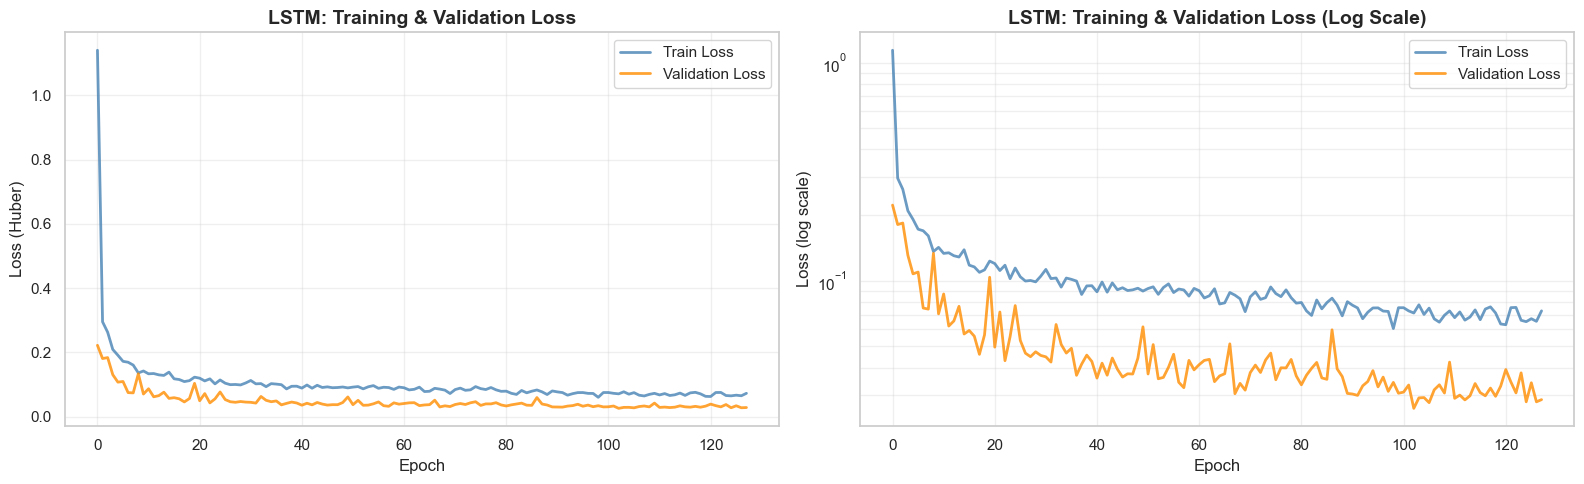


📊 LSTM Training Summary:
   Training time: 2.41 min
   Final train loss: 0.07277
   Final val loss: 0.02850
   Best val loss: 0.02599


In [19]:
lstm_t0 = time.time()
trained_lstm, lstm_train_losses, lstm_val_losses = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=NUM_EPOCHS,
    max_grad_norm=1.0,
    patience=25,
    print_every=10,
    model_name="LSTM"
)
lstm_training_time = time.time() - lstm_t0

# Save LSTM checkpoint
torch.save(trained_lstm.state_dict(), 'models/lstm_demand_model.pth')
print("\n💾 LSTM checkpoint saved to 'models/lstm_demand_model.pth'")

# Plot LSTM training curves
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Linear scale
axes[0].plot(lstm_train_losses, label='Train Loss', linewidth=2, color='steelblue', alpha=0.8)
axes[0].plot(lstm_val_losses, label='Validation Loss', linewidth=2, color='darkorange', alpha=0.8)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss (Huber)', fontsize=12)
axes[0].set_title('LSTM: Training & Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Log scale
axes[1].plot(lstm_train_losses, label='Train Loss', linewidth=2, color='steelblue', alpha=0.8)
axes[1].plot(lstm_val_losses, label='Validation Loss', linewidth=2, color='darkorange', alpha=0.8)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss (log scale)', fontsize=12)
axes[1].set_yscale('log')
axes[1].set_title('LSTM: Training & Validation Loss (Log Scale)', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

print(f"\n📊 LSTM Training Summary:")
print(f"   Training time: {lstm_training_time/60:.2f} min")
print(f"   Final train loss: {lstm_train_losses[-1]:.5f}")
print(f"   Final val loss: {lstm_val_losses[-1]:.5f}")
print(f"   Best val loss: {min(lstm_val_losses):.5f}")

### 7.4.2. GRU


🚀 STARTING GRU TRAINING


Training GRU:   1%|▍                                                                         | 1/150 [00:02<06:08,  2.47s/it]

Epoch [001/150] | Train: 1.52135 | Val: 0.40245 | LR: 0.001200


Training GRU:   7%|████▊                                                                    | 10/150 [00:24<05:46,  2.47s/it]

Epoch [010/150] | Train: 0.29074 | Val: 0.13230 | LR: 0.001200


Training GRU:  13%|█████████▋                                                               | 20/150 [00:49<05:28,  2.53s/it]

Epoch [020/150] | Train: 0.22590 | Val: 0.10352 | LR: 0.001200


Training GRU:  20%|██████████████▌                                                          | 30/150 [01:15<05:10,  2.58s/it]

Epoch [030/150] | Train: 0.19323 | Val: 0.08285 | LR: 0.001200


Training GRU:  27%|███████████████████▍                                                     | 40/150 [01:40<04:42,  2.56s/it]

Epoch [040/150] | Train: 0.16485 | Val: 0.07840 | LR: 0.001200


Training GRU:  33%|████████████████████████▎                                                | 50/150 [02:05<04:07,  2.48s/it]

Epoch [050/150] | Train: 0.17616 | Val: 0.09939 | LR: 0.001200


Training GRU:  40%|█████████████████████████████▏                                           | 60/150 [02:29<03:37,  2.42s/it]

Epoch [060/150] | Train: 0.16677 | Val: 0.08536 | LR: 0.001200


Training GRU:  47%|██████████████████████████████████                                       | 70/150 [02:54<03:18,  2.49s/it]

Epoch [070/150] | Train: 0.15620 | Val: 0.07457 | LR: 0.001200


Training GRU:  53%|██████████████████████████████████████▉                                  | 80/150 [03:20<02:59,  2.56s/it]

Epoch [080/150] | Train: 0.16211 | Val: 0.06588 | LR: 0.001200


Training GRU:  60%|███████████████████████████████████████████▊                             | 90/150 [03:45<02:29,  2.49s/it]

Epoch [090/150] | Train: 0.14862 | Val: 0.08457 | LR: 0.001200


Training GRU:  63%|██████████████████████████████████████████████▏                          | 95/150 [04:00<02:18,  2.53s/it]


⏹️ Early stopping triggered at epoch 96
    No improvement for 25 epochs
    Best validation loss: 0.06393 at epoch 71

✅ Restored best model from epoch 71
✅ Training completed in 4.00 min (240.0s)
🏆 Best Validation Loss: 0.06393 (epoch 71)
📊 Total Epochs Run: 96/150

💾 GRU checkpoint saved to 'models/gru_demand_model.pth'


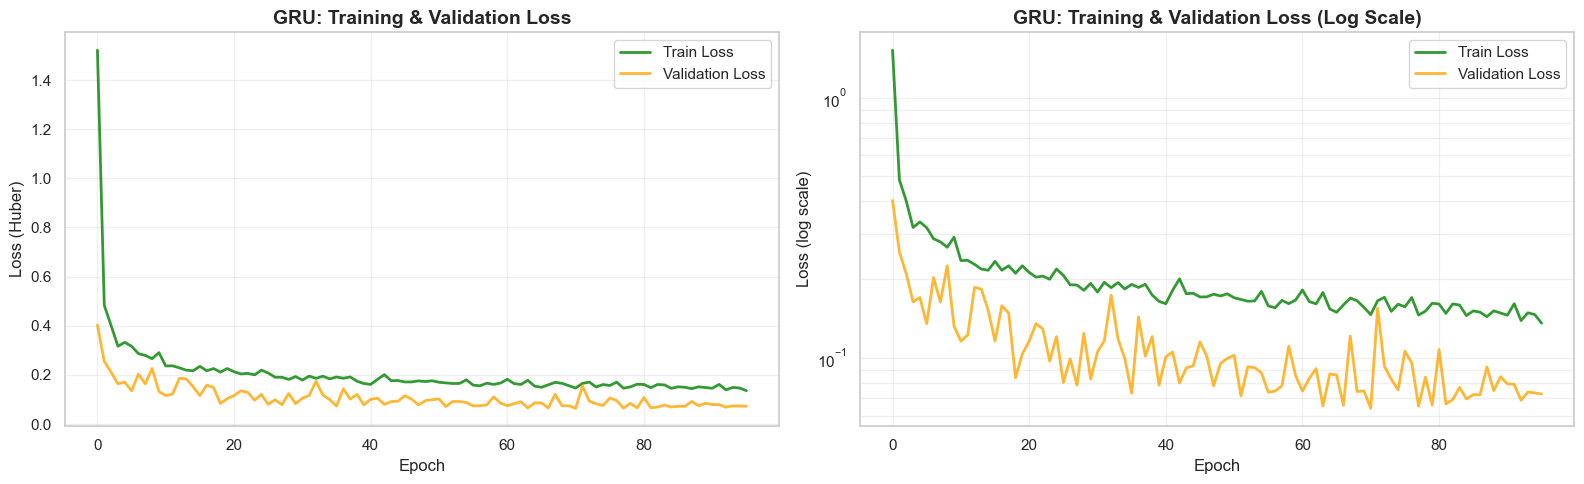


📊 GRU Training Summary:
   Training time: 4.00 min
   Final train loss: 0.13594
   Final val loss: 0.07263
   Best val loss: 0.06393


In [20]:
gru_t0 = time.time()
trained_gru, gru_train_losses, gru_val_losses = train_model(
    model=gru_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=gru_criterion,
    optimizer=gru_optimizer,
    scheduler=gru_scheduler,
    num_epochs=NUM_EPOCHS,
    max_grad_norm=1.0,
    patience=25,
    print_every=10,
    model_name="GRU"
)
gru_training_time = time.time() - gru_t0

# Save GRU checkpoint
torch.save(trained_gru.state_dict(), 'models/gru_demand_model.pth')
print("\n💾 GRU checkpoint saved to 'models/gru_demand_model.pth'")

# Plot GRU training curves
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Linear scale
axes[0].plot(gru_train_losses, label='Train Loss', linewidth=2, color='green', alpha=0.8)
axes[0].plot(gru_val_losses, label='Validation Loss', linewidth=2, color='orange', alpha=0.8)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss (Huber)', fontsize=12)
axes[0].set_title('GRU: Training & Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Log scale
axes[1].plot(gru_train_losses, label='Train Loss', linewidth=2, color='green', alpha=0.8)
axes[1].plot(gru_val_losses, label='Validation Loss', linewidth=2, color='orange', alpha=0.8)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss (log scale)', fontsize=12)
axes[1].set_yscale('log')
axes[1].set_title('GRU: Training & Validation Loss (Log Scale)', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

print(f"\n📊 GRU Training Summary:")
print(f"   Training time: {gru_training_time/60:.2f} min")
print(f"   Final train loss: {gru_train_losses[-1]:.5f}")
print(f"   Final val loss: {gru_val_losses[-1]:.5f}")
print(f"   Best val loss: {min(gru_val_losses):.5f}")

## 7.5. Model Evaluation and Visualization
### 7.5.1. Metrics Functions

In [21]:
def masked_mape(y_true, y_pred, min_actual=10):
    """
    Calculate MAPE only for days with actual demand >= min_actual.
    Avoids division by zero for low-demand days.
    """
    y_true, y_pred = np.asarray(y_true).ravel(), np.asarray(y_pred).ravel()
    mask = y_true >= min_actual
    if mask.sum() == 0:
        return np.nan
    return float(np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100)


def regression_report(y_true, y_pred, min_actual=10):
    """
    Calculate comprehensive regression metrics.
    
    Metrics:
    - MAE: Mean Absolute Error
    - RMSE: Root Mean Squared Error
    - sMAPE: Symmetric Mean Absolute Percentage Error
    - MAPE: Mean Absolute Percentage Error (for demand >= min_actual)
    """
    y_true, y_pred = np.asarray(y_true).ravel(), np.asarray(y_pred).ravel()
    
    mae = float(np.mean(np.abs(y_true - y_pred)))
    rmse = float(np.sqrt(np.mean((y_true - y_pred) ** 2)))
    smape = float(100 * np.mean(2 * np.abs(y_pred - y_true) /
                                (np.abs(y_true) + np.abs(y_pred) + 1e-6)))
    mape = masked_mape(y_true, y_pred, min_actual)
    
    return {"MAE": mae, "RMSE": rmse, "sMAPE%": smape, "MAPE%@>=10": mape}


def evaluate_model(model, loader, name='Test'):
    """
    Generate predictions and compute metrics.
    
    Args:
        model: Trained LSTM/GRU model
        loader: DataLoader (train/val/test)
        name: Name for logging
    
    Returns:
        targets: Ground truth (original scale)
        predictions: Model predictions (original scale)
        metrics: Dictionary of performance metrics
    """
    model.eval()
    preds, targets = [], []
    
    with torch.no_grad():
        for X_batch, Y_batch in loader:
            preds.append(model(X_batch).numpy())
            targets.append(Y_batch.numpy())
    
    # Concatenate batches
    preds_log = np.concatenate(preds, axis=0)
    targs_log = np.concatenate(targets, axis=0)
    
    # Inverse transform: expm1 (undo log1p)
    preds = np.expm1(preds_log).clip(0, None).ravel()
    targs = np.expm1(targs_log).clip(0, None).ravel()
    
    # Compute metrics
    metrics = regression_report(targs, preds, min_actual=10)
    
    return targs, preds, metrics

### 7.5.2. Prepare Evaluation Loaders

In [22]:
print("\n" + "="*70)
print("📊 MODEL EVALUATION")
print("="*70)

# Create evaluation loaders (no shuffle, larger batch for speed)
eval_batch_size = 512

# Reconstruct full train sequences for evaluation (not augmented, not shuffled)
train_eval_dataset = TensorDataset(X_train_seq, Y_train_seq)
test_eval_dataset = TensorDataset(X_test_seq, Y_test_seq)

train_loader_eval = DataLoader(train_eval_dataset, batch_size=eval_batch_size, shuffle=False)
test_loader_eval = DataLoader(test_eval_dataset, batch_size=eval_batch_size, shuffle=False)

print(f"✅ Evaluation loaders created:")
print(f"   Train: {len(train_loader_eval)} batches ({len(train_eval_dataset)} samples)")
print(f"   Test:  {len(test_loader_eval)} batches ({len(test_eval_dataset)} samples)")


📊 MODEL EVALUATION
✅ Evaluation loaders created:
   Train: 3 batches (1076 samples)
   Test:  1 batches (217 samples)


### 7.5.3. Model Evaluation and Baseline Models

In [23]:
# Evaluate LSTM
print("\n🔵 Evaluating LSTM...")

train_targets, train_preds, train_metrics = evaluate_model(
    trained_lstm, train_loader_eval, "Train"
)
test_targets, test_preds, test_metrics = evaluate_model(
    trained_lstm, test_loader_eval, "Test"
)

print(f"   Train samples: {len(train_targets)}")
print(f"   Test samples:  {len(test_targets)}")

# 7.5.4. Evaluate GRU
print("\n🟢 Evaluating GRU...")

gru_train_targets, gru_train_preds, gru_train_metrics = evaluate_model(
    trained_gru, train_loader_eval, "Train"
)
gru_test_targets, gru_test_preds, gru_test_metrics = evaluate_model(
    trained_gru, test_loader_eval, "Test"
)

print(f"   Train samples: {len(gru_train_targets)}")
print(f"   Test samples:  {len(gru_test_targets)}")

# Baseline Models (Naive & Weekly Seasonal)

# Naive baseline: y_pred(t) = y_actual(t-1)
tt = test_targets.ravel()
naive_pred = np.roll(tt, 1)
naive_pred[0] = tt[0]  # Handle first element

# Weekly seasonal: y_pred(t) = y_actual(t-7)
weekly_pred = np.roll(tt, 7)
weekly_pred[:7] = tt[:7]  # Handle first week

# Compute baseline metrics
naive_metrics = regression_report(tt, naive_pred, min_actual=10)
weekly_metrics = regression_report(tt, weekly_pred, min_actual=10)


🔵 Evaluating LSTM...
   Train samples: 1076
   Test samples:  217

🟢 Evaluating GRU...
   Train samples: 1076
   Test samples:  217


### 7.5.4. Performance Comparison Tables

In [24]:
print("\n" + "="*70)
print("📊 BASELINES SUMMARY (Test Set)")
print("="*70)

print(f"\n  Naive (t-1):")
for k, v in naive_metrics.items():
    print(f"     {k:15s}: {v:8.2f}")

print(f"\n  Weekly Seasonal (t-7):")
for k, v in weekly_metrics.items():
    print(f"     {k:15s}: {v:8.2f}")

# LSTM vs GRU comparison
comparison_data = {
    'Metric': ['MAE', 'RMSE', 'sMAPE%', 'MAPE%@>=10'],
    'LSTM Train': [
        train_metrics['MAE'],
        train_metrics['RMSE'],
        train_metrics['sMAPE%'],
        train_metrics['MAPE%@>=10']
    ],
    'GRU Train': [
        gru_train_metrics['MAE'],
        gru_train_metrics['RMSE'],
        gru_train_metrics['sMAPE%'],
        gru_train_metrics['MAPE%@>=10']
    ],
    'LSTM Test': [
        test_metrics['MAE'],
        test_metrics['RMSE'],
        test_metrics['sMAPE%'],
        test_metrics['MAPE%@>=10']
    ],
    'GRU Test': [
        gru_test_metrics['MAE'],
        gru_test_metrics['RMSE'],
        gru_test_metrics['sMAPE%'],
        gru_test_metrics['MAPE%@>=10']
    ]
}

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*86)
print("📊 PERFORMANCE COMPARISON: LSTM vs GRU")
print("="*86)
print(comparison_df.to_string(index=False, col_space=14, float_format=lambda x: f"{x:,.2f}"))

# Training time comparison
print("\n⏱️ Training Time:")
print(f"   LSTM: {lstm_training_time/60:.2f} min ({lstm_training_time:.1f} s)")
print(f"   GRU:  {gru_training_time/60:.2f} min ({gru_training_time:.1f} s)")

time_diff = abs(lstm_training_time - gru_training_time)
faster_model = "GRU" if gru_training_time < lstm_training_time else "LSTM"
print(f"   Faster: {faster_model} (by {time_diff:.1f}s)")

# Winner by Test MAE
lstm_test_mae = test_metrics['MAE']
gru_test_mae = gru_test_metrics['MAE']
winner = "LSTM" if lstm_test_mae < gru_test_mae else "GRU"
improvement = abs(lstm_test_mae - gru_test_mae) / max(lstm_test_mae, gru_test_mae) * 100

print(f"\n🏆 Winner (by Test MAE): {winner}")
print(f"   Advantage: {improvement:.2f}%")

# vs Baselines
print(f"\n📐 vs Baselines (Test Set):")
print(f"   Naive MAE: {naive_metrics['MAE']:.2f}")
print(f"   LSTM Improvement: {((naive_metrics['MAE'] - lstm_test_mae)/naive_metrics['MAE']*100):+.1f}%")
print(f"   GRU Improvement:  {((naive_metrics['MAE'] - gru_test_mae)/naive_metrics['MAE']*100):+.1f}%")


📊 BASELINES SUMMARY (Test Set)

  Naive (t-1):
     MAE            :  3804.17
     RMSE           :  5666.31
     sMAPE%         :    36.54
     MAPE%@>=10     :    48.37

  Weekly Seasonal (t-7):
     MAE            :  3677.02
     RMSE           :  5514.38
     sMAPE%         :    39.61
     MAPE%@>=10     :    54.71

📊 PERFORMANCE COMPARISON: LSTM vs GRU
        Metric     LSTM Train      GRU Train      LSTM Test       GRU Test
           MAE       1,228.55       1,403.89       2,005.98       2,128.97
          RMSE       1,965.25       2,370.24       2,777.06       2,966.67
        sMAPE%          13.70          15.90          25.29          24.11
    MAPE%@>=10          14.86          17.35          30.39          31.13

⏱️ Training Time:
   LSTM: 2.41 min (144.5 s)
   GRU:  4.00 min (240.0 s)
   Faster: LSTM (by 95.5s)

🏆 Winner (by Test MAE): LSTM
   Advantage: 5.78%

📐 vs Baselines (Test Set):
   Naive MAE: 3804.17
   LSTM Improvement: +47.3%
   GRU Improvement:  +44.0%


### 7.5.5. Timeline Reconstruction

In [25]:
# Reconstruct dates for train/test sequences (warmup (30) + sequence window (60))
train_start_idx = WARMUP_DAYS + SEQUENCE_LENGTH
train_end_idx = train_start_idx + len(train_targets)

test_start_idx = WARMUP_DAYS + len(X_train_scaled) + SEQUENCE_LENGTH
test_end_idx = test_start_idx + len(test_targets)

# Load dates from aggregated_daily_df
dates = pd.to_datetime(aggregated_daily_df['Date'])
train_dates = dates.iloc[train_start_idx:train_end_idx].reset_index(drop=True)
test_dates = dates.iloc[test_start_idx:test_end_idx].reset_index(drop=True)

print(f"   Train dates: {train_dates.iloc[0]} to {train_dates.iloc[-1]} ({len(train_dates)} days)")
print(f"   Test dates:  {test_dates.iloc[0]} to {test_dates.iloc[-1]} ({len(test_dates)} days)")

# Handle IsSynthetic Days (if present)
if 'IsSynthetic' in aggregated_daily_df.columns:
    print("\n🔍 Checking for synthetic days in evaluation period...")
    
    # Extract IsSynthetic flags for train/test
    train_synthetic = aggregated_daily_df['IsSynthetic'].iloc[train_start_idx:train_end_idx].values
    test_synthetic = aggregated_daily_df['IsSynthetic'].iloc[test_start_idx:test_end_idx].values
    
    train_synthetic_count = int(train_synthetic.sum())
    test_synthetic_count = int(test_synthetic.sum())
    
    print(f"   Train: {train_synthetic_count} synthetic days ({train_synthetic_count/len(train_synthetic)*100:.1f}%)")
    print(f"   Test:  {test_synthetic_count} synthetic days ({test_synthetic_count/len(test_synthetic)*100:.1f}%)")
    
    if test_synthetic_count > 0:
        print(f"\n   ⚠️  Note: {test_synthetic_count} test days are synthetic (forward-filled)")
        print(f"      Metrics include these days, but they may affect accuracy estimates")
else:
    print("\n✅ No 'IsSynthetic' column found - all days are real observations")

   Train dates: 2018-07-12 00:00:00 to 2021-06-21 00:00:00 (1076 days)
   Test dates:  2021-08-31 00:00:00 to 2022-04-04 00:00:00 (217 days)

🔍 Checking for synthetic days in evaluation period...
   Train: 0 synthetic days (0.0%)
   Test:  0 synthetic days (0.0%)


### 7.5.6. Model Comparison and Visualisation

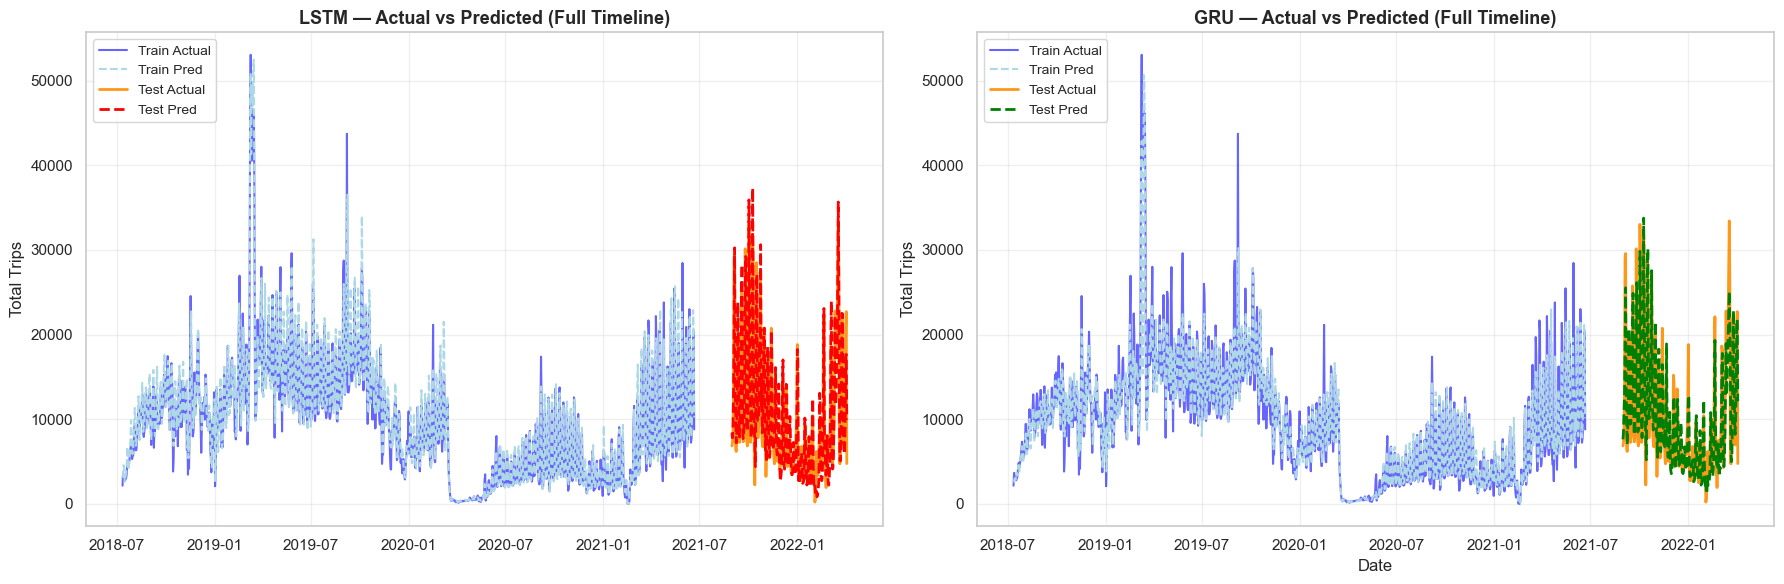

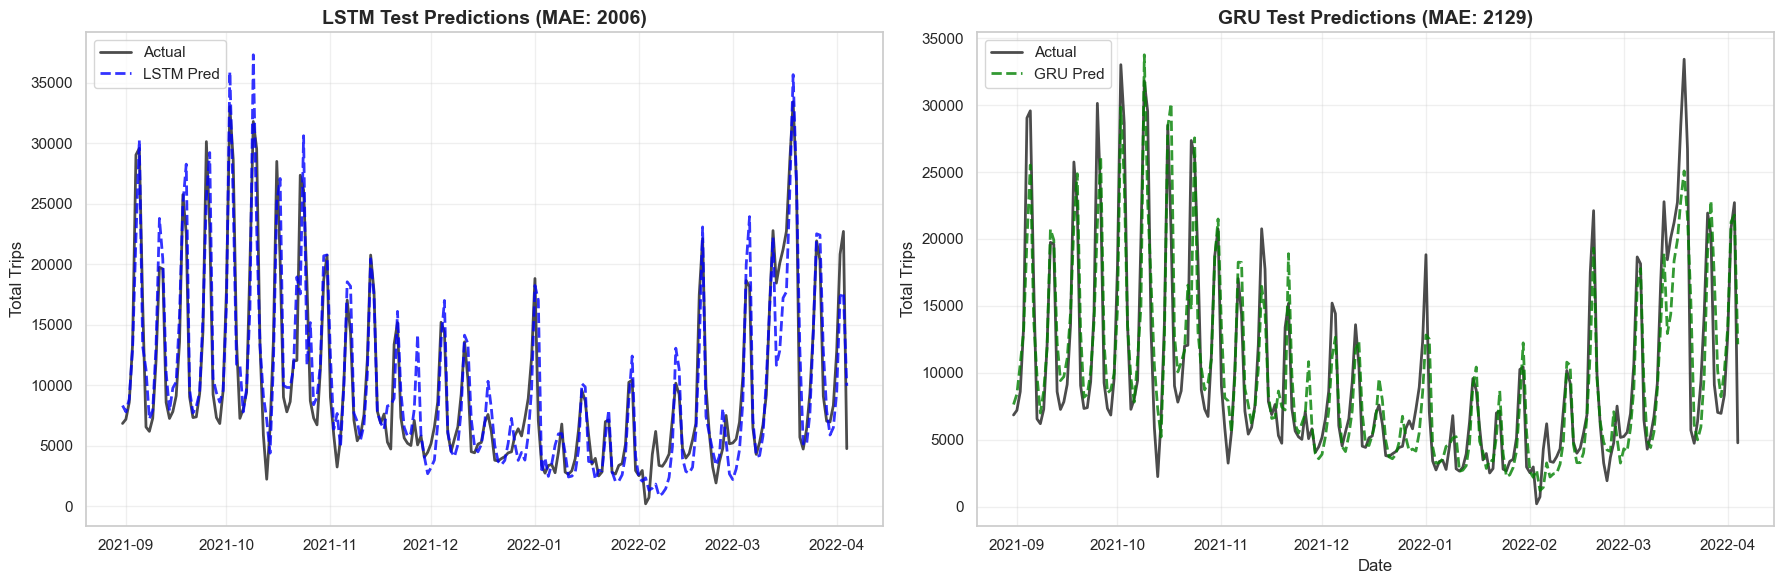

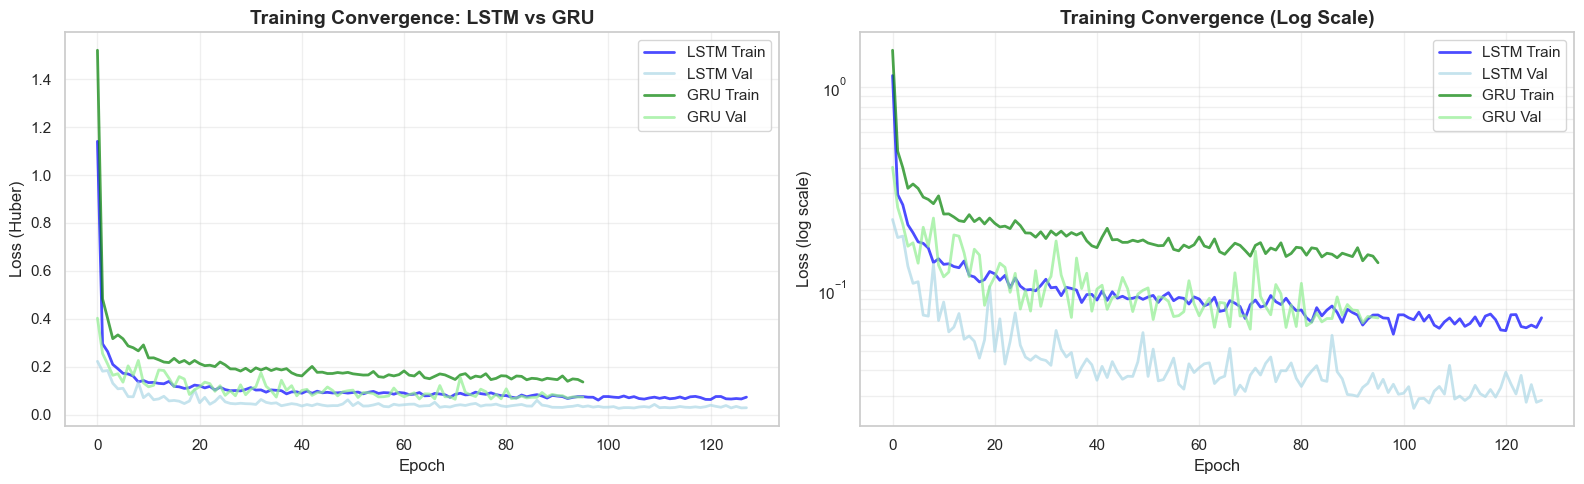

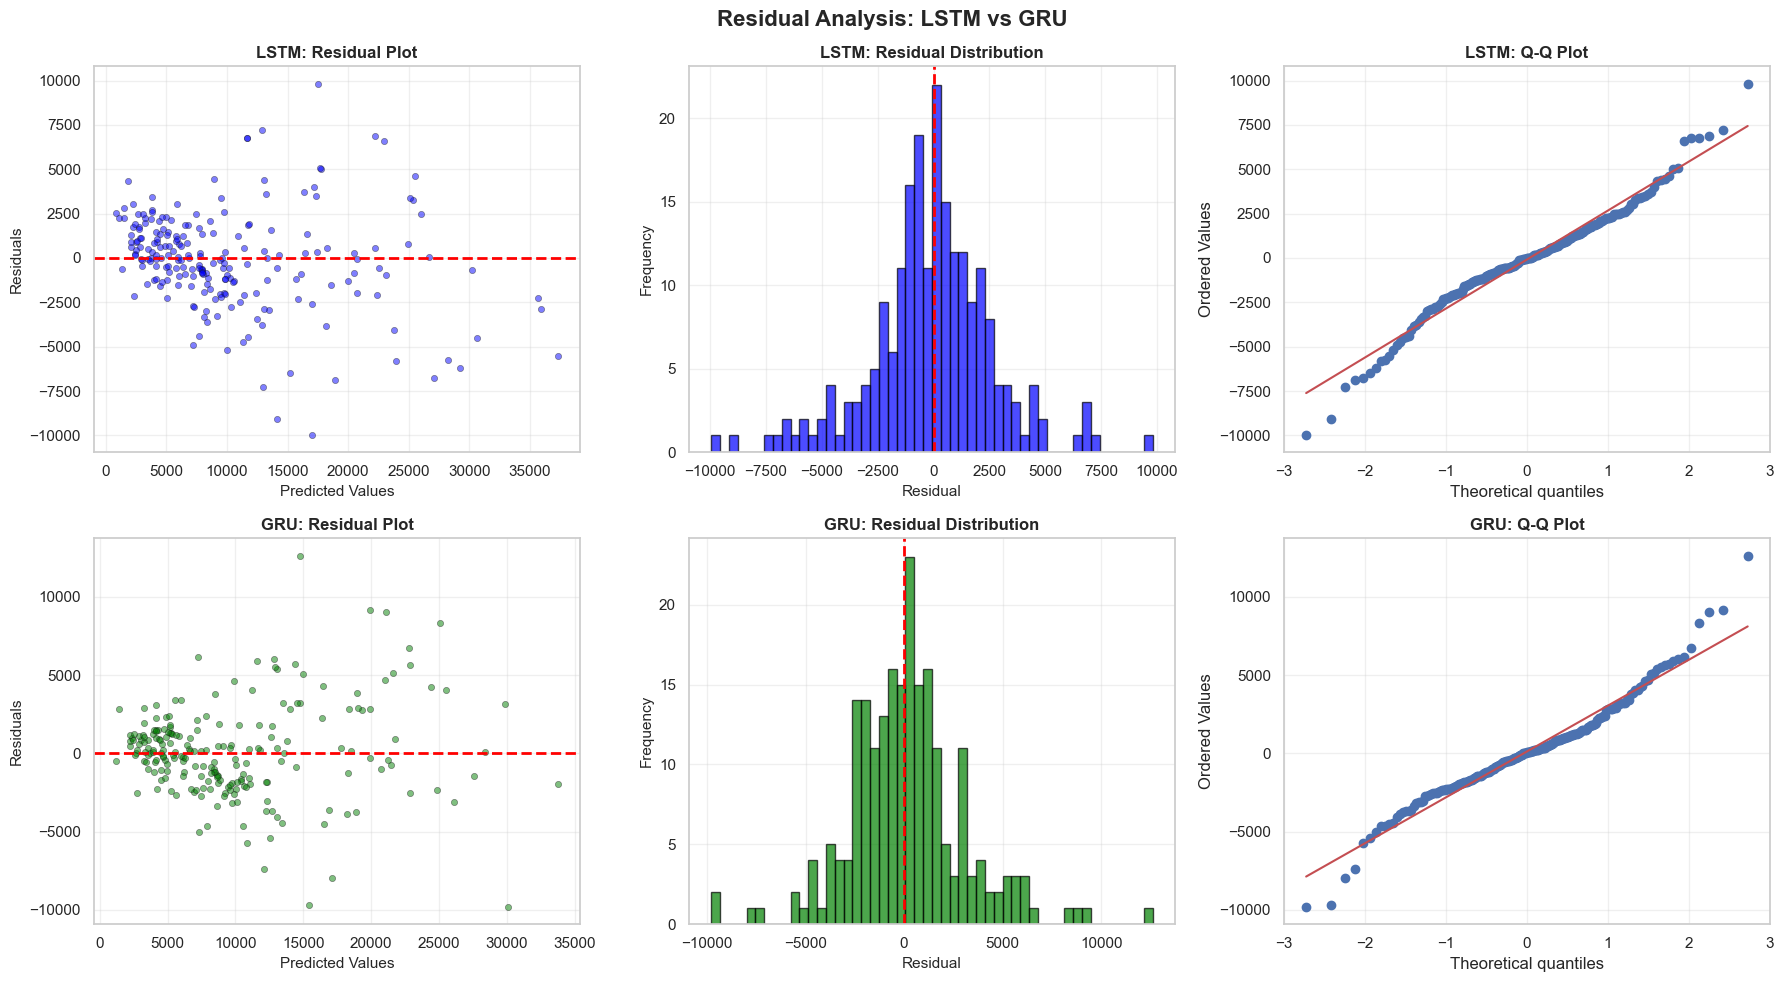

In [26]:
# Plot 1: Full Timeline (Train + Test)
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# LSTM
axes[0].plot(train_dates, train_targets, label='Train Actual', 
             color='blue', alpha=0.6, lw=1.5)
axes[0].plot(train_dates, train_preds, label='Train Pred', 
             color='lightblue', ls='--', lw=1.5)
axes[0].plot(test_dates, test_targets, label='Test Actual', 
             color='darkorange', alpha=0.9, lw=2.0)
axes[0].plot(test_dates, test_preds, label='Test Pred', 
             color='red', ls='--', lw=2.0)
axes[0].set_title("LSTM — Actual vs Predicted (Full Timeline)", 
                  fontsize=13, fontweight='bold')
axes[0].set_ylabel("Total Trips", fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].legend(loc='upper left', fontsize=10)

# GRU
axes[1].plot(train_dates, gru_train_targets, label='Train Actual', 
             color='blue', alpha=0.6, lw=1.5)
axes[1].plot(train_dates, gru_train_preds, label='Train Pred', 
             color='lightblue', ls='--', lw=1.5)
axes[1].plot(test_dates, gru_test_targets, label='Test Actual', 
             color='darkorange', alpha=0.9, lw=2.0)
axes[1].plot(test_dates, gru_test_preds, label='Test Pred', 
             color='green', ls='--', lw=2.0)
axes[1].set_title("GRU — Actual vs Predicted (Full Timeline)", 
                  fontsize=13, fontweight='bold')
axes[1].set_xlabel("Date", fontsize=12)
axes[1].set_ylabel("Total Trips", fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].legend(loc='upper left', fontsize=10)

plt.tight_layout()
plt.show()

# Plot 2: Test Set Predictions (Side-by-Side)
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# LSTM Test
axes[0].plot(test_dates, test_targets, label='Actual', 
             color='black', alpha=0.7, linewidth=2)
axes[0].plot(test_dates, test_preds, label='LSTM Pred', 
             color='blue', linestyle='--', linewidth=2, alpha=0.8)
axes[0].set_title(f"LSTM Test Predictions (MAE: {lstm_test_mae:.0f})", 
                  fontsize=14, fontweight='bold')
axes[0].set_ylabel("Total Trips", fontsize=12)
axes[0].legend(loc='upper left', fontsize=11)
axes[0].grid(True, alpha=0.3)

# GRU Test
axes[1].plot(test_dates, gru_test_targets, label='Actual', 
             color='black', alpha=0.7, linewidth=2)
axes[1].plot(test_dates, gru_test_preds, label='GRU Pred', 
             color='green', linestyle='--', linewidth=2, alpha=0.8)
axes[1].set_title(f"GRU Test Predictions (MAE: {gru_test_mae:.0f})", 
                  fontsize=14, fontweight='bold')
axes[1].set_xlabel("Date", fontsize=12)
axes[1].set_ylabel("Total Trips", fontsize=12)
axes[1].legend(loc='upper left', fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Plot 3: Training Convergence Comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Linear scale
axes[0].plot(lstm_train_losses, label='LSTM Train', linewidth=2, 
             color='blue', alpha=0.7)
axes[0].plot(lstm_val_losses, label='LSTM Val', linewidth=2, 
             color='lightblue', alpha=0.7)
axes[0].plot(gru_train_losses, label='GRU Train', linewidth=2, 
             color='green', alpha=0.7)
axes[0].plot(gru_val_losses, label='GRU Val', linewidth=2, 
             color='lightgreen', alpha=0.7)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss (Huber)', fontsize=12)
axes[0].set_title('Training Convergence: LSTM vs GRU', 
                  fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Log scale
axes[1].plot(lstm_train_losses, label='LSTM Train', linewidth=2, 
             color='blue', alpha=0.7)
axes[1].plot(lstm_val_losses, label='LSTM Val', linewidth=2, 
             color='lightblue', alpha=0.7)
axes[1].plot(gru_train_losses, label='GRU Train', linewidth=2, 
             color='green', alpha=0.7)
axes[1].plot(gru_val_losses, label='GRU Val', linewidth=2, 
             color='lightgreen', alpha=0.7)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss (log scale)', fontsize=12)
axes[1].set_yscale('log')
axes[1].set_title('Training Convergence (Log Scale)', 
                  fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()


# Plot 4: Residual Analysis
lstm_residuals = test_targets - test_preds
gru_residuals = gru_test_targets - gru_test_preds

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Residual Analysis: LSTM vs GRU', fontsize=16, fontweight='bold')

# LSTM Residuals (Row 1)
# Residual scatter plot
axes[0, 0].scatter(test_preds, lstm_residuals, alpha=0.5, 
                   color='blue', edgecolors='k', linewidth=0.5, s=20)
axes[0, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0, 0].set_title('LSTM: Residual Plot', fontweight='bold', fontsize=12)
axes[0, 0].set_xlabel('Predicted Values', fontsize=11)
axes[0, 0].set_ylabel('Residuals', fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# Residual histogram
axes[0, 1].hist(lstm_residuals, bins=50, edgecolor='black', 
                color='blue', alpha=0.7)
axes[0, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0, 1].set_title('LSTM: Residual Distribution', fontweight='bold', fontsize=12)
axes[0, 1].set_xlabel('Residual', fontsize=11)
axes[0, 1].set_ylabel('Frequency', fontsize=11)
axes[0, 1].grid(True, alpha=0.3)

# Q-Q plot
stats.probplot(lstm_residuals, dist="norm", plot=axes[0, 2])
axes[0, 2].set_title('LSTM: Q-Q Plot', fontweight='bold', fontsize=12)
axes[0, 2].grid(True, alpha=0.3)

# GRU Residuals (Row 2)
# Residual scatter plot
axes[1, 0].scatter(gru_test_preds, gru_residuals, alpha=0.5, 
                   color='green', edgecolors='k', linewidth=0.5, s=20)
axes[1, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_title('GRU: Residual Plot', fontweight='bold', fontsize=12)
axes[1, 0].set_xlabel('Predicted Values', fontsize=11)
axes[1, 0].set_ylabel('Residuals', fontsize=11)
axes[1, 0].grid(True, alpha=0.3)

# Residual histogram
axes[1, 1].hist(gru_residuals, bins=50, edgecolor='black', 
                color='green', alpha=0.7)
axes[1, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1, 1].set_title('GRU: Residual Distribution', fontweight='bold', fontsize=12)
axes[1, 1].set_xlabel('Residual', fontsize=11)
axes[1, 1].set_ylabel('Frequency', fontsize=11)
axes[1, 1].grid(True, alpha=0.3)

# Q-Q plot
stats.probplot(gru_residuals, dist="norm", plot=axes[1, 2])
axes[1, 2].set_title('GRU: Q-Q Plot', fontweight='bold', fontsize=12)
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 7.5.7. Summary Statistics

In [27]:
print("\n" + "="*70)
print("📊 RESIDUAL ANALYSIS SUMMARY")
print("="*70)

print(f"\nLSTM Residuals:")
print(f"   Mean:   {np.mean(lstm_residuals):8.2f}")
print(f"   Std:    {np.std(lstm_residuals):8.2f}")
print(f"   Min:    {np.min(lstm_residuals):8.2f}")
print(f"   Max:    {np.max(lstm_residuals):8.2f}")
print(f"   Median: {np.median(lstm_residuals):8.2f}")

print(f"\nGRU Residuals:")
print(f"   Mean:   {np.mean(gru_residuals):8.2f}")
print(f"   Std:    {np.std(gru_residuals):8.2f}")
print(f"   Min:    {np.min(gru_residuals):8.2f}")
print(f"   Max:    {np.max(gru_residuals):8.2f}")
print(f"   Median: {np.median(gru_residuals):8.2f}")

print("\n" + "="*70)
print(f"\n📁 Saved Artifacts:")
print(f"   - lstm_demand_model.pth (trained LSTM weights)")
print(f"   - gru_demand_model.pth (trained GRU weights)")


📊 RESIDUAL ANALYSIS SUMMARY

LSTM Residuals:
   Mean:     -87.37
   Std:     2775.68
   Min:    -9954.68
   Max:     9811.91
   Median:   -10.37

GRU Residuals:
   Mean:     121.82
   Std:     2964.17
   Min:    -9789.75
   Max:    12618.93
   Median:    79.25


📁 Saved Artifacts:
   - lstm_demand_model.pth (trained LSTM weights)
   - gru_demand_model.pth (trained GRU weights)


# 8. Production Inference System
## 8.1. Model Loader Class

In [29]:
class ModelLoader:
    """Φορτώνει το εκπαιδευμένο LSTM/GRU μοντέλο και τα preprocessing artifacts."""
    
    def __init__(self, model_type='lstm', model_dir='models'):  # ← Άλλαξε default
        """
        Args:
            model_type: 'lstm' ή 'gru'
            model_dir: Φάκελος όπου βρίσκονται τα .pth files
        """
        self.model_type = model_type.lower()
        self.model_dir = model_dir
        
        # Paths
        self.model_path = os.path.join(model_dir, f'{model_type}_demand_model.pth')
        self.scaler_path = os.path.join(model_dir, 'feature_scaler.pkl')
        self.features_path = os.path.join(model_dir, 'input_features.json')
        
        # Έλεγχος ύπαρξης αρχείων
        self._check_files()
        
        # Φόρτωση artifacts
        self.feature_scaler = self._load_scaler()
        self.input_features = self._load_features()
        self.lag_idxs = self._compute_lag_idxs()
        self.model = self._load_model()
    
    def _check_files(self):
        """Ελέγχει αν υπάρχουν τα απαραίτητα αρχεία."""
        missing = []
        if not os.path.exists(self.model_path):
            missing.append(self.model_path)
        if not os.path.exists(self.scaler_path):
            missing.append(self.scaler_path)
        if not os.path.exists(self.features_path):
            missing.append(self.features_path)
        
        if missing:
            raise FileNotFoundError(
                f"❌ Missing required files:\n" + "\n".join(f"  - {f}" for f in missing) +
                f"\n\n💡 Please run Section 7 (Training) first to generate these files."
            )
    
    def _load_scaler(self):
        """Φορτώνει τον StandardScaler."""
        with open(self.scaler_path, 'rb') as f:
            return pickle.load(f)
    
    def _load_features(self):
        """Φορτώνει τα ονόματα των features."""
        with open(self.features_path, 'r') as f:
            return json.load(f)
    
    def _compute_lag_idxs(self):
        """Υπολογίζει τα indices των lag features για το AR component."""
        LAG_FEATURE_NAMES = ['TotalTrips_Lag1', 'TotalTrips_Lag7']
        lag_idxs = [self.input_features.index(n) for n in LAG_FEATURE_NAMES 
                    if n in self.input_features]
        return lag_idxs
    
    def _load_model(self):
        """
        Φορτώνει το εκπαιδευμένο μοντέλο.
        Χρησιμοποιεί τα GLOBAL hyperparameters από το Section 7.
        """
        INPUT_SIZE_INFERENCE = len(self.input_features)
        
        # Χρήση GLOBAL variables από το training
        try:
            # Επιλογή model class
            if self.model_type == 'lstm':
                model = TwoWheelerLSTM(
                    input_size=INPUT_SIZE_INFERENCE,
                    hidden_size=HIDDEN_SIZE,
                    num_layers=NUM_LAYERS,
                    output_size=OUTPUT_SIZE,
                    dropout_rate=DROPOUT_RATE
                )
            else:  # gru
                model = TwoWheelerGRU(
                    input_size=INPUT_SIZE_INFERENCE,
                    hidden_size=HIDDEN_SIZE,
                    num_layers=NUM_LAYERS,
                    output_size=OUTPUT_SIZE,
                    dropout_rate=DROPOUT_RATE
                )
        except NameError as e:
            raise RuntimeError(
                f"❌ Required global variable not found: {e}\n"
                f"💡 Make sure you've run Section 7.3 (Model Definition) first.\n"
                f"   Required variables: HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE, DROPOUT_RATE"
            )
        
        # Φόρτωση εκπαιδευμένων weights
        try:
            model.load_state_dict(torch.load(self.model_path, map_location='cpu'))
        except Exception as e:
            raise RuntimeError(
                f"❌ Failed to load model weights from {self.model_path}\n"
                f"   Error: {e}\n"
                f"💡 Make sure the model was trained with the same architecture."
            )
        
        model.eval()  # Inference mode
        
        return model

## 8.2. Data Preprocessor

In [30]:
class DemandPreprocessor:
    """
    Προετοιμάζει τα raw δεδομένα της εταιρίας για inference.
    """
    def __init__(self, feature_names, scaler):
        self.feature_names = feature_names
        self.scaler = scaler
        self.sequence_length = SEQUENCE_LENGTH  # Χρησιμοποιούμε το global variable
    
    def prepare_data(self, df):
        """
        Μετατρέπει raw trip data σε model-ready format.
        
        Args:
            df: DataFrame με στήλες ['Date', 'TotalTrips', 'TotalUniqueDevices',
                                     'MedianDuration', 'MedianDistance']
        
        Returns:
            X: Scaled feature tensor (1, seq_len, features)
            last_date: Τελευταία ημερομηνία των δεδομένων
            df: Επεξεργασμένο DataFrame (για iterative forecasting)
        """
        # 1) Ταξινόμηση κατά ημερομηνία
        df = df.sort_values('Date').reset_index(drop=True)
        df['Date'] = pd.to_datetime(df['Date'])
        
        # 1b) Ανακατασκευή ημερολογίου (reindex + ffill)
        # Αυτό διασφαλίζει ότι αν η εταιρία δώσει δεδομένα με "τρύπες" σε μέρες, το μοντέλο θα έχει συνεχή ακολουθία (όπως στο training).
        df = df.set_index('Date')
        full_idx = pd.date_range(df.index.min(), df.index.max(), freq='D')
        df = df.reindex(full_idx)
        
        # ffill μόνο στις continuous μεταβλητές
        cols_ffill = ['TotalTrips','TotalUniqueDevices','MedianDuration','MedianDistance']
        df[cols_ffill] = df[cols_ffill].ffill()
        
        # Επαναφορά index
        df = df.reset_index().rename(columns={'index':'Date'})
        
        # 2) Προσθήκη calendar features
        df['DayOfWeek'] = df['Date'].dt.dayofweek
        df['Month'] = df['Date'].dt.month
        df['Season'] = df['Month'].apply(self._month_to_season)
        
        # Cyclical encodings
        df['DayOfWeek_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
        df['DayOfWeek_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)
        df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
        df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
        df['Season_sin'] = np.sin(2 * np.pi * df['Season'] / 4)
        df['Season_cos'] = np.cos(2 * np.pi * df['Season'] / 4)
        
        # 3) Προσθήκη lag features
        df['TotalTrips_Lag1'] = df['TotalTrips'].shift(1).fillna(0)
        df['TotalTrips_Lag7'] = df['TotalTrips'].shift(7).fillna(0)
        
        # 4) Έλεγχος ελάχιστου μήκους δεδομένων
        if len(df) < self.sequence_length:
            raise ValueError(
                f"❌ Need at least {self.sequence_length} days of historical data.\n"
                f"   Got only {len(df)} days.\n"
                f"   Please provide more data."
            )
        
        # 5) Εξαγωγή features (τελευταίες 60 ημέρες)
        recent_data = df.tail(self.sequence_length).copy()
        X = recent_data[self.feature_names].values.astype(np.float32)
        
        # 6) Scaling (χρησιμοποιούμε τον ίδιο scaler από το training)
        X_scaled = self.scaler.transform(X)
        
        # 7) Μετατροπή σε tensor (batch_size=1, seq_len, features)
        X_tensor = torch.tensor(X_scaled, dtype=torch.float32).unsqueeze(0)
        
        # 8) Τελευταία ημερομηνία (για το forecasting)
        last_date = df['Date'].iloc[-1]
        
        return X_tensor, last_date, df
    
    @staticmethod
    def _month_to_season(month):
        """Χαρτογράφηση μήνα σε εποχή (0-3)"""
        if month in [12, 1, 2]:
            return 0  # Winter
        elif month in [3, 4, 5]:
            return 1  # Spring
        elif month in [6, 7, 8]:
            return 2  # Summer
        else:
            return 3  # Autumn

## 8.3. Weekly Forecaster

In [31]:
class WeeklyForecaster:
    """
    Παράγει πρόβλεψη ζήτησης για τις επόμενες 7 ημέρες.
    Χρησιμοποιεί iterative forecasting (autoregressive approach).
    """
    def __init__(self, model_loader):
        self.model = model_loader.model
        self.preprocessor = DemandPreprocessor(
            model_loader.input_features,
            model_loader.feature_scaler
        )
    
    def predict_week(self, df):
        """
        Προβλέπει ζήτηση για τις επόμενες 7 ημέρες.
        
        Args:
            df: Ιστορικά δεδομένα (minimum 60 ημέρες) με columns:
                ['Date', 'TotalTrips', 'TotalUniqueDevices', 
                 'MedianDuration', 'MedianDistance']
        
        Returns:
            forecast_df: DataFrame με ['Date', 'Predicted_Trips', 'DayOfWeek']
        """
        # 1) Προετοιμασία input
        X, last_date, historical_df = self.preprocessor.prepare_data(df)
        
        # 2) Δημιουργία forecast dates (επόμενες 7 ημέρες)
        forecast_dates = [last_date + timedelta(days=i+1) for i in range(7)]
        
        # 3) Iterative forecasting (βήμα-προς-βήμα)
        predictions = []
        current_sequence = X.clone()  # (1, 60, 11)
        
        for day_idx, target_date in enumerate(forecast_dates):
            # Πρόβλεψη για την επόμενη ημέρα
            with torch.no_grad():
                pred_log = self.model(current_sequence).numpy()  # (1, 1)
            
            # Inverse log1p (επιστροφή στην αρχική κλίμακα)
            pred_trips = np.expm1(pred_log).clip(0, None).item()
            predictions.append(pred_trips)
            
            # Κατασκευή features για την επόμενη ημέρα
            next_features = self._construct_next_features(
                historical_df, target_date, pred_trips
            )
            
            # Scaling των νέων features
            next_features_scaled = self.preprocessor.scaler.transform(
                next_features.reshape(1, -1)
            )
            
            # Ενημέρωση sequence: αφαίρεση πρώτου timestep, προσθήκη νέου
            next_tensor = torch.tensor(next_features_scaled, dtype=torch.float32)
            current_sequence = torch.cat([
                current_sequence[:, 1:, :],    # Διαγραφή πρώτης ημέρας
                next_tensor.unsqueeze(0)       # Προσθήκη προβλεπόμενης ημέρας
            ], dim=1)
            
            # Ενημέρωση historical data (για επόμενη iteration)
            historical_df = pd.concat([
                historical_df,
                pd.DataFrame({
                    'Date': [target_date],
                    'TotalTrips': [pred_trips],
                    'TotalUniqueDevices': [historical_df['TotalUniqueDevices'].iloc[-1]],
                    'MedianDuration': [historical_df['MedianDuration'].iloc[-1]],
                    'MedianDistance': [historical_df['MedianDistance'].iloc[-1]],
                    'DayOfWeek': [target_date.weekday()],
                    'Month': [target_date.month],
                    'Season': [self.preprocessor._month_to_season(target_date.month)]
                })
            ], ignore_index=True)
            
            # Ενημέρωση lag features για την επόμενη πρόβλεψη
            historical_df['TotalTrips_Lag1'] = historical_df['TotalTrips'].shift(1).fillna(0)
            historical_df['TotalTrips_Lag7'] = historical_df['TotalTrips'].shift(7).fillna(0)
        
        # 4) Δημιουργία forecast DataFrame
        forecast_df = pd.DataFrame({
            'Date': forecast_dates,
            'Predicted_Trips': predictions,
            'DayOfWeek': [d.strftime('%A') for d in forecast_dates]
        })
        
        return forecast_df
    
    def _construct_next_features(self, df, target_date, predicted_trips):
        """
        Κατασκευάζει το feature vector για την επόμενη ημέρα.
        """
        # Calendar features
        dow = target_date.weekday()
        month = target_date.month
        season = self.preprocessor._month_to_season(month)
        
        dow_sin = np.sin(2 * np.pi * dow / 7)
        dow_cos = np.cos(2 * np.pi * dow / 7)
        month_sin = np.sin(2 * np.pi * month / 12)
        month_cos = np.cos(2 * np.pi * month / 12)
        season_sin = np.sin(2 * np.pi * season / 4)
        season_cos = np.cos(2 * np.pi * season / 4)
        
        # Lag features (χρησιμοποιούμε τα πιο πρόσφατα δεδομένα)
        lag1 = df['TotalTrips'].iloc[-1]  # Χθεσινή ζήτηση
        lag7 = df['TotalTrips'].iloc[-7] if len(df) >= 7 else lag1  # Πριν από 7 ημέρες
        
        # Supply features (υποθέτουμε σταθερό στόλο)
        devices = df['TotalUniqueDevices'].iloc[-1]
        
        # Trip characteristics (υποθέτουμε σταθερά)
        duration = df['MedianDuration'].iloc[-1]
        distance = df['MedianDistance'].iloc[-1]
        
        # Κατασκευή feature vector
        features = np.array([
            dow_sin, dow_cos,
            month_sin, month_cos,
            season_sin, season_cos,
            lag1, lag7,
            devices,
            duration, distance
        ], dtype=np.float32)
        
        return features

## 8.4. Main Inference Function

In [32]:
def forecast_demand(csv_path, model_type='lstm', plot=True):
    """
    Πλήρης inference pipeline για εξωτερικές εταιρίες.
    
    Args:
        csv_path: Path προς το CSV αρχείο της εταιρίας
        model_type: 'lstm' ή 'gru'
        plot: Αν True, δημιουργεί visualizations
    
    Returns:
        forecast_df: 7-day demand predictions
    
    📋 Απαιτούμενη μορφή CSV:
        - Date: YYYY-MM-DD
        - TotalTrips: Ημερήσιος αριθμός ταξιδιών
        - TotalUniqueDevices: Ενεργά οχήματα
        - MedianDuration: Διάμεση διάρκεια ταξιδιού (seconds)
        - MedianDistance: Διάμεση απόσταση ταξιδιού (meters)
        
        Τουλάχιστον 60 ημέρες δεδομένων!
    """
    print("\n" + "="*70)
    print("🚀 MICROMOBILITY DEMAND FORECASTING SYSTEM")
    print("="*70)
    
    # 1) Φόρτωση δεδομένων
    print(f"\n📂 Loading data from: {csv_path}")
    try:
        df = pd.read_csv(csv_path, parse_dates=['Date'])
    except FileNotFoundError:
        raise FileNotFoundError(f"❌ CSV file not found: {csv_path}")
    except Exception as e:
        raise ValueError(f"❌ Error reading CSV: {e}")
    
    # Έλεγχος στηλών
    required_cols = ['Date', 'TotalTrips', 'TotalUniqueDevices', 'MedianDuration', 'MedianDistance']
    missing_cols = [c for c in required_cols if c not in df.columns]
    if missing_cols:
        raise ValueError(
            f"❌ Missing required columns in CSV:\n" + 
            "\n".join(f"  - {c}" for c in missing_cols) +
            f"\n\n Required columns: {required_cols}"
        )
    
    print(f"   ✅ Loaded {len(df)} days of historical data")
    print(f"   Date range: {df['Date'].min().date()} to {df['Date'].max().date()}")
    
    # 2) Φόρτωση μοντέλου
    loader = ModelLoader(model_type=model_type)
    
    # 3) Αρχικοποίηση forecaster
    forecaster = WeeklyForecaster(loader)
    
    # 4) Δημιουργία πρόβλεψης
    forecast_df = forecaster.predict_week(df)
    
    # 5) Εμφάνιση αποτελεσμάτων
    print("\n" + "="*70)
    print("📊 FORECAST RESULTS (Next 7 Days)")
    print("="*70)
    print(forecast_df.to_string(index=False, float_format=lambda x: f'{x:,.0f}'))
    print("\n" + "="*70)
    
    # 6) Visualization
    if plot:
        _plot_forecast(df, forecast_df, model_type)
    
    return forecast_df

def _plot_forecast(historical_df, forecast_df, model_type):
    """
    Οπτικοποίηση ιστορικών δεδομένων + πρόβλεψης.
    """
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    
    # Plot 1: Τελευταίες 90 ημέρες + forecast
    recent_history = historical_df.tail(90).copy()
    
    axes[0].plot(recent_history['Date'], recent_history['TotalTrips'], label='Historical', color='steelblue', linewidth=2.5, alpha=0.8)
    axes[0].plot(forecast_df['Date'], forecast_df['Predicted_Trips'], 
                 label='Forecast', color='red', linewidth=2.5, marker='o', linestyle='--', markersize=8, alpha=0.9)
    axes[0].axvline(x=recent_history['Date'].iloc[-1], color='gray', linestyle=':', linewidth=2, label='Today', alpha=0.7)
    axes[0].set_title(f'Demand Forecast — {model_type.upper()} Model (Next 7 Days)', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Date', fontsize=12)
    axes[0].set_ylabel('Total Trips', fontsize=12)
    axes[0].legend(fontsize=11, loc='upper left')
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Weekly forecast breakdown
    colors = ['#FF6B6B' if i == forecast_df['Predicted_Trips'].idxmax() 
              else '#4ECDC4' for i in range(len(forecast_df))]
    
    axes[1].bar(forecast_df['DayOfWeek'], forecast_df['Predicted_Trips'], 
               color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    axes[1].set_title('Predicted Demand by Day of Week', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Day of Week', fontsize=12)
    axes[1].set_ylabel('Predicted Trips', fontsize=12)
    axes[1].grid(True, alpha=0.3, axis='y')
    
    # Annotations για peak day
    max_idx = forecast_df['Predicted_Trips'].idxmax()
    max_val = forecast_df.loc[max_idx, 'Predicted_Trips']
    axes[1].annotate(f'Peak: {max_val:,.0f}', 
                    xy=(max_idx, max_val), 
                    xytext=(max_idx, max_val * 1.1),
                    ha='center', fontsize=10, fontweight='bold',
                    arrowprops=dict(arrowstyle='->', color='red', lw=2))
    
    plt.tight_layout()
    plt.show()

## 8.5. Example Usage


🚀 MICROMOBILITY DEMAND FORECASTING SYSTEM

📂 Loading data from: outputs/company_example_data.csv
   ✅ Loaded 90 days of historical data
   Date range: 2022-01-05 to 2022-04-04

📊 FORECAST RESULTS (Next 7 Days)
      Date  Predicted_Trips DayOfWeek
2022-04-05            4,157   Tuesday
2022-04-06            3,922 Wednesday
2022-04-07            4,065  Thursday
2022-04-08            4,881    Friday
2022-04-09            5,573  Saturday
2022-04-10            3,420    Sunday
2022-04-11            1,600    Monday



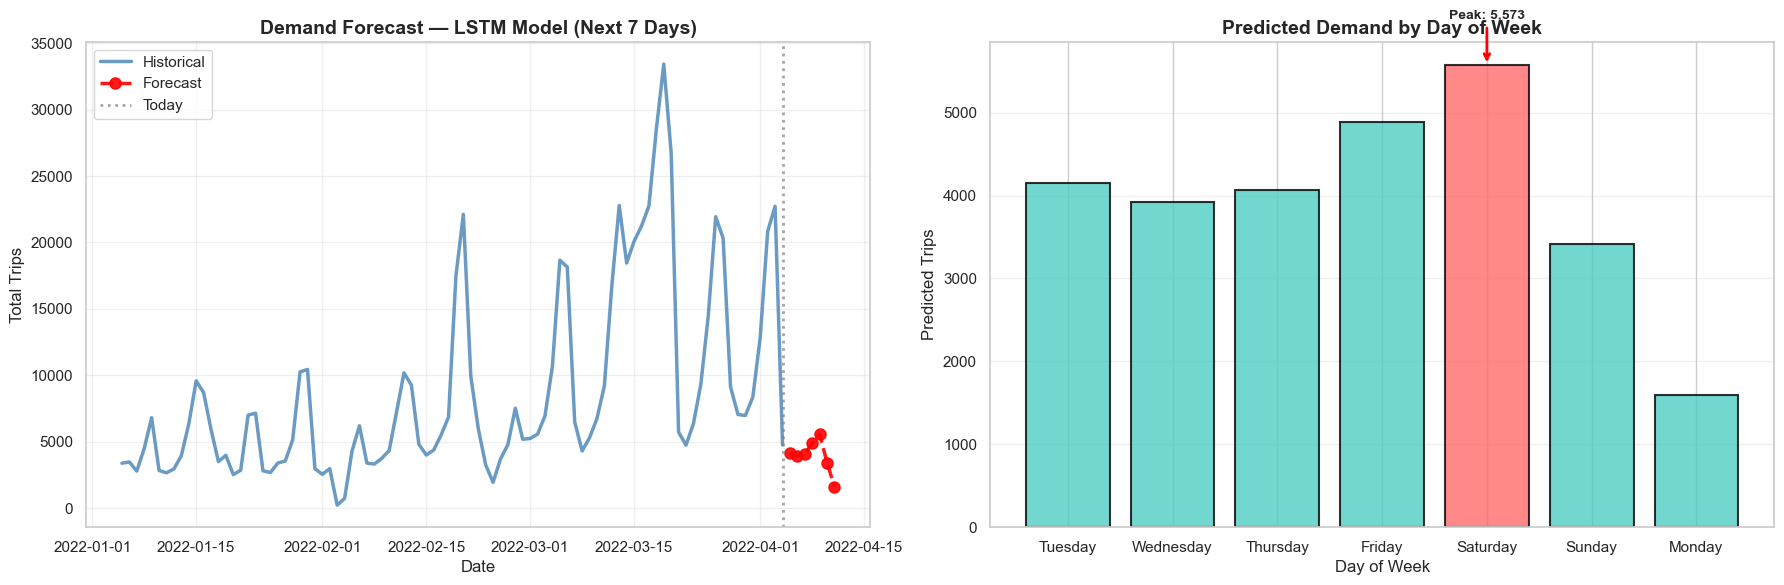



📊 LSTM Model Results:
 Weekly Total:   27,617 trips
 Daily Average:    3,945 trips
 Peak Day: Saturday (5,573 trips)
 Low Day:   Monday (1,600 trips)

📁 Saved Files:
 • outputs/company_example_data.csv (input)
 • outputs/lstm_forecast_next_week.csv (forecast)



In [33]:
# ΡΥΘΜΙΣΗ: Διάλεξε ποιο μοντέλο να χρησιμοποιήσεις
INFERENCE_MODEL = 'lstm'  # 🔴 Άλλαξε σε 'lstm' ή 'gru'

"""
# Προετοιμασία example data
print(f"\n📝 Preparing example company data...")
demo_data = pd.read_csv('data/processed/final_daily_micromobility_data.csv', parse_dates=['Date'])
company_data = demo_data[['Date', 'TotalTrips', 'TotalUniqueDevices', 'MedianDuration', 'MedianDistance']].tail(90).copy()
company_data.to_csv('outputs/company_example_data.csv', index=False)
print(f" ✅ Created: outputs/company_example_data.csv ({len(company_data)} days)")
"""

# Εκτέλεση forecast
forecast = forecast_demand(csv_path='outputs/company_example_data.csv', model_type=INFERENCE_MODEL, plot=True)

# Αποθήκευση
output_filename = f'outputs/{INFERENCE_MODEL}_forecast_next_week.csv'
forecast.to_csv(output_filename, index=False)

# Τελικό summary
print("\n" + "="*70)
print(f"\n📊 {INFERENCE_MODEL.upper()} Model Results:")
print(f" Weekly Total: {forecast['Predicted_Trips'].sum():>8,.0f} trips")
print(f" Daily Average: {forecast['Predicted_Trips'].mean():>8,.0f} trips")
print(f" Peak Day: {forecast.loc[forecast['Predicted_Trips'].idxmax(), 'DayOfWeek']:>8s} ({forecast['Predicted_Trips'].max():,.0f} trips)")
print(f" Low Day: {forecast.loc[forecast['Predicted_Trips'].idxmin(), 'DayOfWeek']:>8s} ({forecast['Predicted_Trips'].min():,.0f} trips)")

print(f"\n📁 Saved Files:")
print(f" • outputs/company_example_data.csv (input)")
print(f" • {output_filename} (forecast)")
print("\n" + "="*70)